# Melbourne Housing Market – <br> Dealing with missing data when building a predictive model
The __goal__ of this notebook is to __simulate a real-life business scenario__ where a company needs to leverage on a predictive model to successfully implement or enhance a business strategy.

With that in mind, we’re trying to work through the challenges of building a working model that can __add value__ to a company rather than just getting the highest accuracy. This perspective, and real-life constrains (particularly around missing data) will inform many of the decisions in this notebook.

On a personal note, I emphasized explaining the reasons behind every key decision throughout the notebook. Some of the ideas or explanations might be inaccurate, but in any case arbitrary.

The notebook is still live and I will continue to add/enhance content.

__Data Source__: [Kaggle Melbourne Housing Market](https://www.kaggle.com/anthonypino/melbourne-housing-market/data)



## Index
Fill index

## Scenario: Build a classifier to find houses with more than three rooms
We are part of __a company that works in interior design__ of residential spaces. After dissecting the company’s sales, we realize that, though only 20% come from __houses or apartments that have more than three rooms__, these __sales make up to a 70% of the total revenue__. The executive decides to __focus on this high-margin segment__ of the market as part of a new business strategy.

Our main sales channel is a call-center. The cost of customer acquisition is directly related to the number of calls that an agent has to place before finding a potential match. The company wants to maintain acquisition costs while targeting this specific segment. For this reason, they asks us to __build a predictive model using publicly available data that will help target potential customers and reduce useless calls as much as possible__.

The company, present throughout Australia, wants to start launching a pilot on Melbourne. Currently there’s one sales agent assigned part-time to this city with capacity to make an average of 20 calls a day. We want to make those 20 calls as effective as possible and avoid calling customers that don’t fit the criteria.

## Modules

In [1264]:
import re
import itertools
import time
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import mstats
from fancyimpute import KNN, MICE

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (recall_score, accuracy_score, precision_score,
                             precision_recall_curve)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.2)

pd.set_option('display.max_colwidth', -1)

## Load Data

In [1265]:
#Load into dataframe
path = '/Users/Stephanie/desktop/thinkful/capstone - supervised learning/'
file = 'Melbourne_housing_FULL.csv'

data = pd.read_csv(path + file)

## Explore high-level attributes

In [1266]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [1267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

A first quick look shows the following:
* Our dataset is composed by 35k entries and 22 variables.
* Some variables are continuous (e.g. _Price_), some discrete (e.g. _Rooms_), and some others are categorical (e.g. _Type_) plus a time variable (_Date_).
* Many variables have missing data.
* _Date_ is stored as a strings.
* _Postcode_ is stored as a float number but it’s actually a categorical variable.

In [1268]:
# convert date data type to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Postcode'] = data['Postcode'].apply(lambda x: x if np.isnan(x) == True else str(int(x)))

## Exclude bedroom2 variable from dataset
_Rooms_ and _bedroom2_ are very highly correlated as seen below. _Bedroom2_ is, as defined in the [data source overview]( https://www.kaggle.com/anthonypino/melbourne-housing-market), the number of Bedrooms, scraped from a different source. A model that incorporates it as a feature can easily go over a 0.99 accuracy. However, we’ll assume that this variable is not available in our scenario, which will force us to explore more in depth issues as missing data, feature selection, and different trade-offs in model tuning.

Also, note that, as scraped from another source, there seem to be some inconsistencies as in some cases the house lists more bedrooms than total rooms.

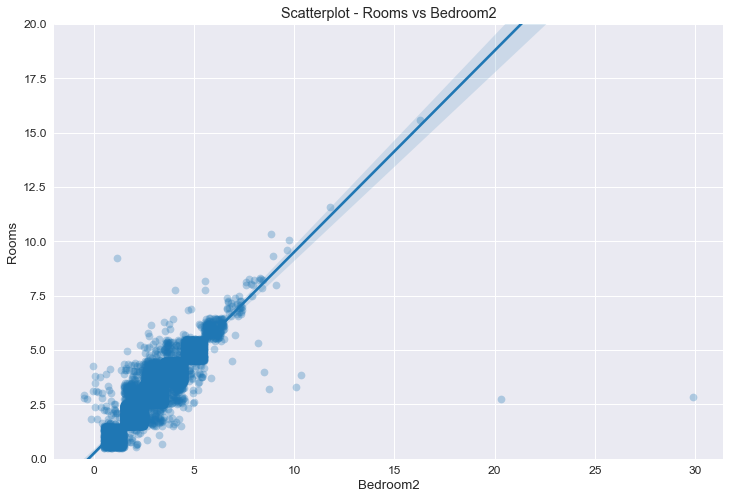

In [1269]:
# plot scatter rooms/bedroom2
plt.figure(figsize=(12,8))
plt.title('Scatterplot - Rooms vs Bedroom2')
ax = sns.regplot(data['Bedroom2'], data['Rooms'],
                 x_jitter=0.5, y_jitter=0.5, scatter_kws={'alpha': 0.3, 's':60})
ax.set_ylim([0,20])
plt.show()

In [1270]:
data.drop('Bedroom2', axis=1, inplace=True)

## Split data into train and test sets
We are going to cross-validate our model on a train set with an 80% data and hold a 20% to run a final test of our results. The test set represents future data that would feed the model once in production. To avoid any data leakage the test set will stay far from our analysis until the very final test.

The power of a predictive model comes from its capacity to predict unknown data (in our case, the test set). Data leakage occurs when our model _tastes_ test data while being trained. Test data must remain unknown when exploring the distribution and completion of missing data, and when preprocessing it. An example of data leakage can occur when imputing missing data. In this case we use the mean of a variable to fill the gaps. If to calculate that mean we use the whole data set instead of just the train set, part of the test information is leaking to the train set into the model. In purity the same process should apply between folders during the cross-validation to avoid contamination but won’t since we have a separate set to run a final test.

In [1271]:
train, test = train_test_split(data, test_size=0.2, random_state=13)
datasets = [train, test]

## Missing Data

We already know some variables have missing values. We need to assess how serious is the issue.

In [1272]:
cols_with_na = len(train.columns[train.isna().any() == True])
total_cols = len(train.columns)

print('%d out of %d variables have missing data'%(cols_with_na, total_cols))

13 out of 20 variables have missing data


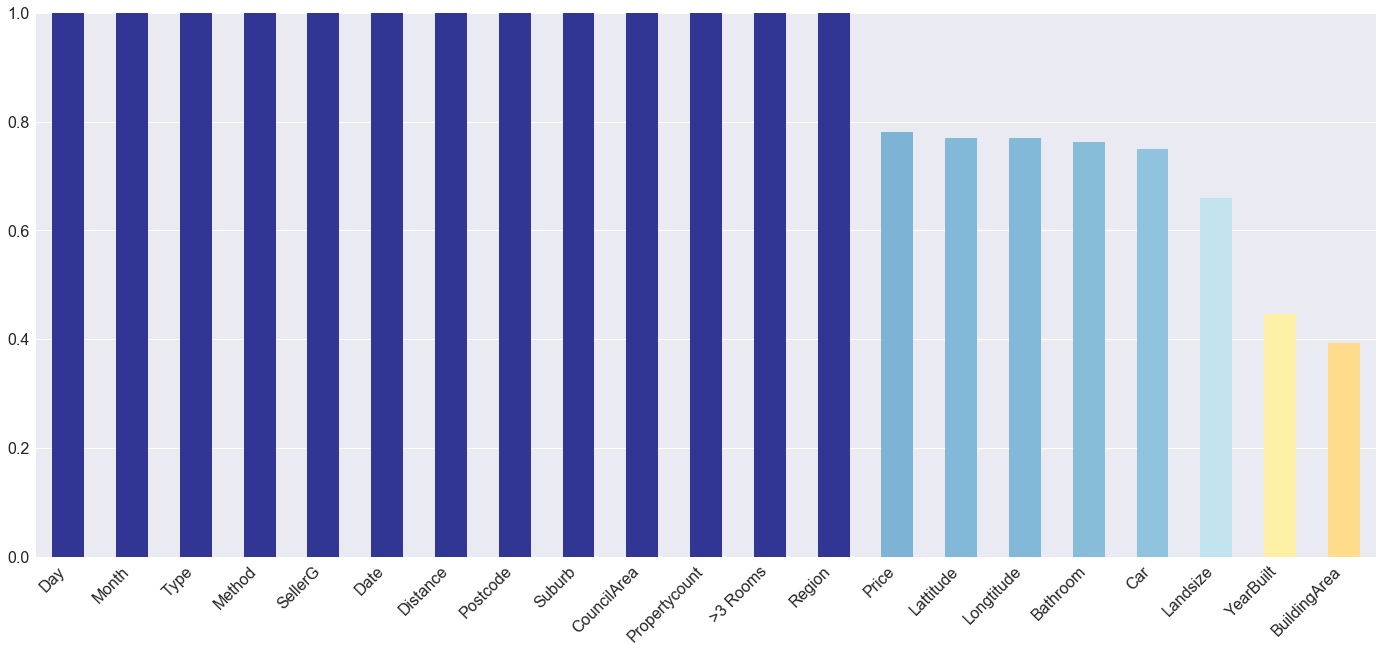

In [1542]:
count_sorted = train.count().sort_values(ascending=False)
df_sorted = train[count_sorted.index]
columns_count = len(count_sorted)

y = count_sorted.values
colors = cm.RdYlBu(y / float(max(y)))

sns.set_style('darkgrid')
msno.bar(df_sorted, color=colors)
ax = plt.axes() 
ax.xaxis.grid(False)
plt.show()

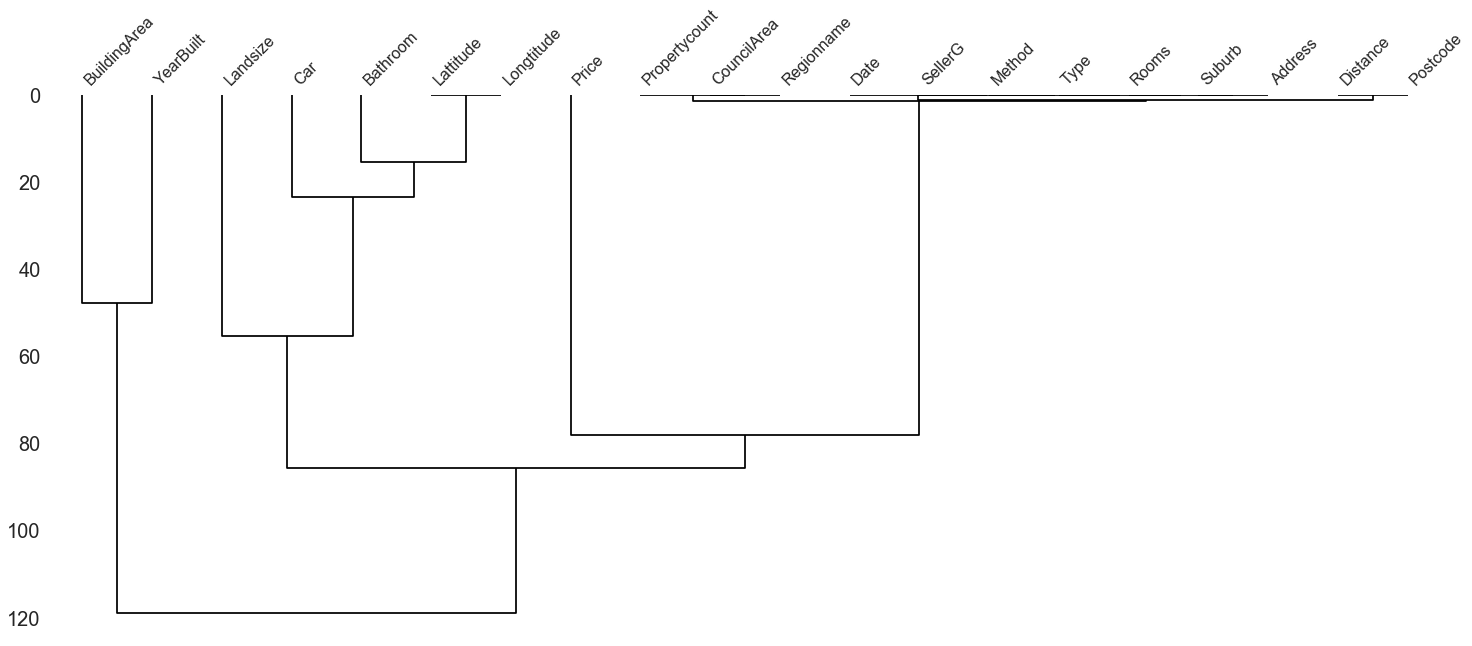

In [1274]:
msno.dendrogram(train)
plt.show()

__Description of the problem__ <br>
14 out of 21 variables have missing data. However, as appreciated in the bar chat above, that number is negligible (3 or less entries missing) for 5 of those variables, and a further look to the dendrogram below the bar chart tell us that they all belong to the same three rows. So for simplifying purposes of this exercise, we’re going to drop them from the dataset, but if we were to keep them, we would have the same approach when imputing as the rest of variables with missing data (just using _mode_ instead of _median_ as they’re categorical data).

The good news from the dendrogram is that the variable seem to miss data pretty independently. This means that, though most of the rows are missing information at some level, in most cases we don’t miss data from all variables at the same time. The emptier fields for a sale are, the less accurate the prediction will be.

In [1275]:
# all these missing values belong to the same three rows that we'll remove
# we wouldn't remove them from the original dataframe if it was a higher number
for df in datasets:
    drop = df[df['Propertycount'].isna()].index
    print('Rows dropped:', len(drop))
    df.drop(drop, inplace=True)

Rows dropped: 2
Rows dropped: 1


The rest of variables are missing at least a 20% of the data, which is very significant and challenging. The situation is particularly serious for _Building Area_ since it performs as a top predictor in both of our models but it’s missing in over a 50% of the sales.

Below we can see how the missing data is distributed in a random sample of 200 sales.

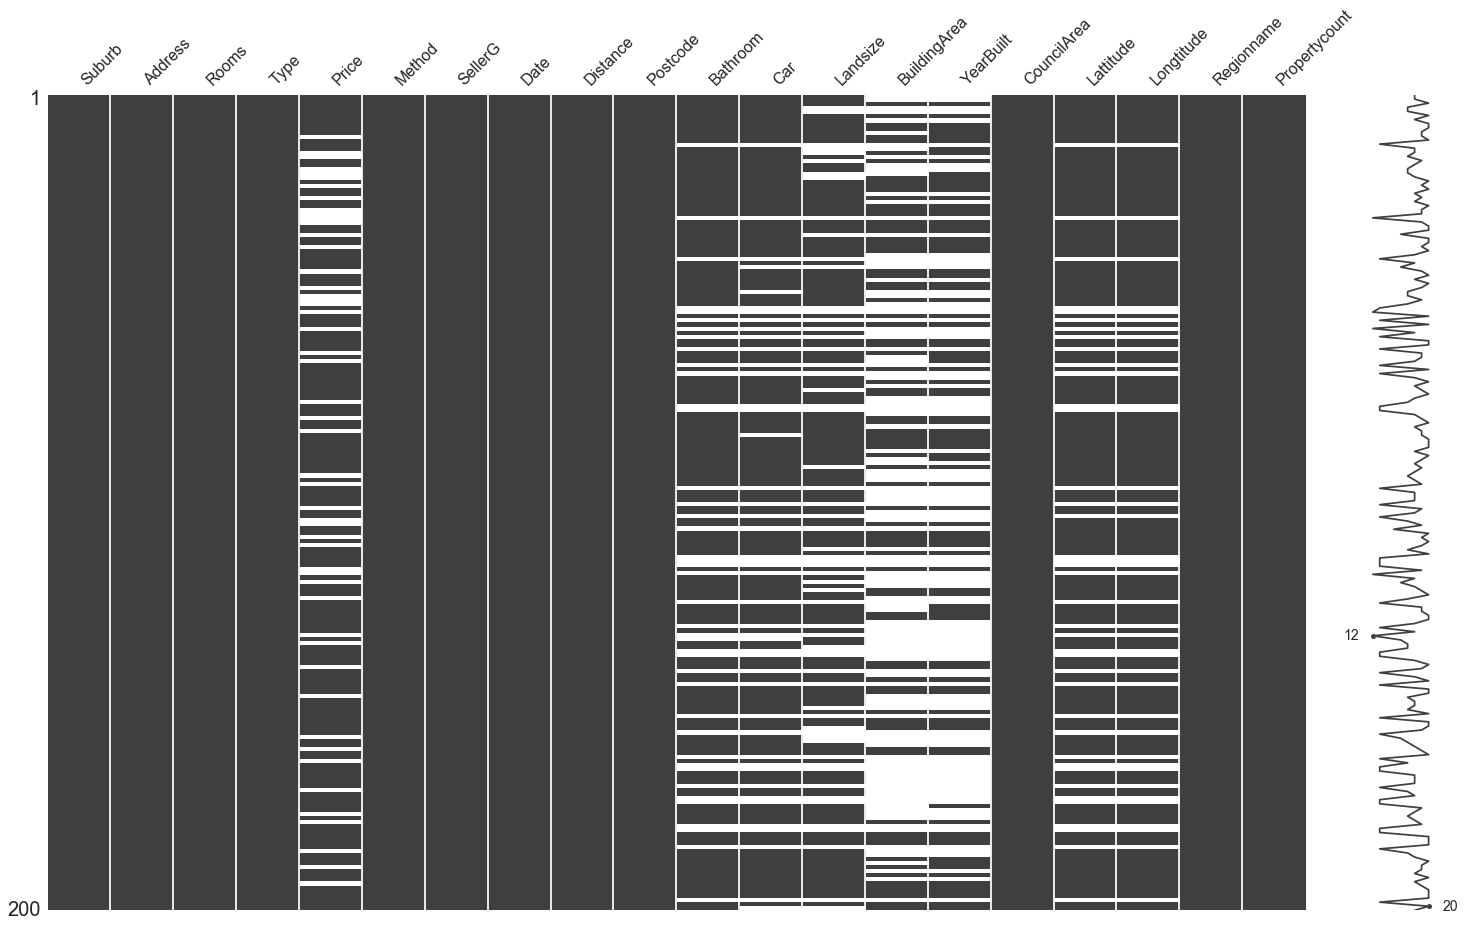

In [1276]:
msno.matrix(train.sample(200), figsize=(25,15))
plt.show()

__Approach__ 
We have a number of options when dealing with missing data.
* Drop rows
* Drop variables with missing data
* Create a dummy variable indicating whether a variable is missing or not for each sale.
* Impute the data.

If we discard existing information (dropping entire rows or columns with missing values) we’ll increase the variance error. By imputing missing fields we keep that information but create new one that can bias our model.

__Dropping rows with missing values__: though a very common approach, in our case dropping rows with any missing value implies reducing our dataset a 75%. That is: our model will discard 3 out of every 4 sales, and we wouldn’t identify enough leads to fully utilize the call-center.

__Dropping variables with nan values__: domain knowledge suggests that the fields with missing data are precisely the most likely to be part of the feature selection. Discarding them would result in a lower score than imputing the data.

__Create nan dummies__: since we have so many fields with missing data this would add to much complexity, also if the data is missing at random it won’t really help. Maybe since _Building Area_ is so important, we could try only with this variable (_to go in a future update_).

__Impute data__: we will impute the data using different methods and compare how these results differ from a scenario where we drop all the data. We will combine this with a threshold to drop some of the rows with more missing values for an optimal result.

## Methods to impute missing data
The most common imputing method is to use the variable’s mean (it can also be the median or mode). However, we need to be aware that this reduces the variance of the variable (as more values coincide with the mean).

In addition to the mean, the median or the mode can also be used. In our case, all variables with missing values are numerical (discrete or continuous). With discrete variables it makes sense to use the median as we ensure to impute an integer. Using the median can be also a good idea if our data presents outliers, as it’s not affected as much by them as the mean does. Using the mean on a variable skewed due to outliers can introduce more bias to the model. We’ll go over this things throughout the notebook.

Since we’re missing so much data, imputing will be critical to our model so we’ll try different approaches lie imputing the mean/median by groups defined by another categorical variable or using other imputing solutions as MICE imputation or KNN neighbors.


## Data distribution of numerical variables 

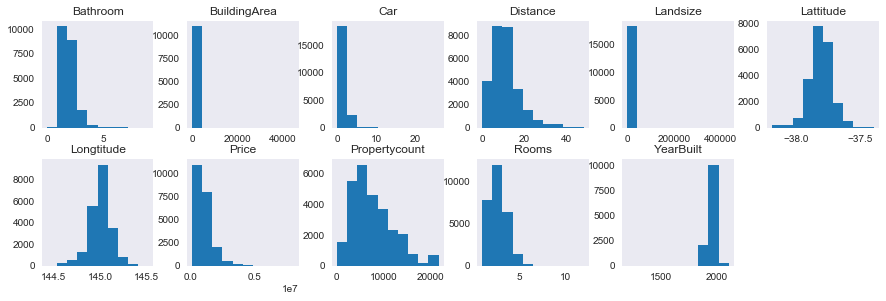

In [1277]:
sns.set(font_scale=1, palette='tab10')
to_plot = train.select_dtypes(include=['float64', 'int'])
to_plot.hist(figsize=(15, 4.5), grid=False, layout=(2,6))
plt.show()

For most variables, a few outliers are compressing the data to fall under a few bins, compressing the data to the left and ‘hiding’ the shape of the actual distribution. A house can be ridiculously big and expensive, so these are not necessarily an error. One variable, however, stands out, as the oldest building in Melbourne dates from 1839 but the x-grid in our histogram goes below that number.

In [1278]:
## Look at correlation between region or postcode and these variables

In [1279]:
outliers = train['YearBuilt'] < 1850
train.loc[outliers , 'YearBuilt']

3533     1830.0
16424    1196.0
Name: YearBuilt, dtype: float64

Indeed, it seems like 1196 was typed instead of 1916. The other value could be possibly 1930, but since it’s pretty close within the year-range and just one value we’ll leave it as it is.

In [1280]:
train.loc[16424,'YearBuilt'] = 1916

To get a better picture of the distribution we’re going to plot the data moving outliers within a 99% confidence interval (winsorizing). We won’t apply this transformation for our classification model but select algorithms that work well with outliers: random forest are not sensitive to them and logistic regressions are not greatly affected as well (especially in comparison to other models as a liner regression due their different loss functions).

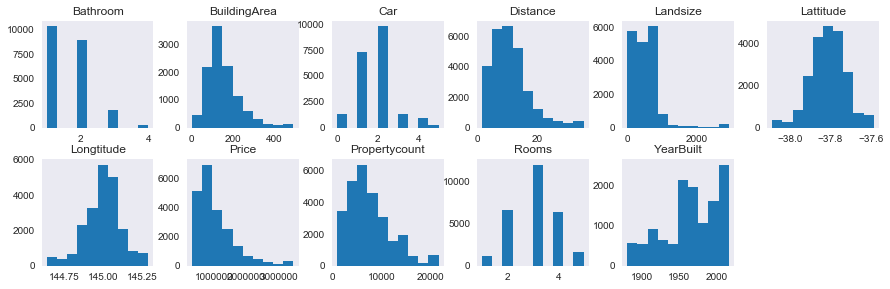

In [1281]:
# Winsorize data
to_plot_win = to_plot.copy()

for col in to_plot_win:
    not_null = to_plot[col].notnull()
    to_plot_win.loc[not_null, col] = mstats.winsorize(to_plot.loc[not_null, col], limits=0.01)

# plot winsorized data
to_plot_win = to_plot_win.select_dtypes(include=['float64', 'int'])
to_plot_win.hist(figsize=(15, 4.5), grid=False, layout=(2,6))
plt.show()

We get much more detail once the data is winsorized. Some variables present a normal distribution and others are skewed. We could apply a log transform __bla bla bla mention impact of distribution on models etc.__

Explain approach

Some skewed could log transform but no need with logistic regression or random forest, maybe after for linear regression

## Mean, Median and Outliers
On one had we have variables with missing data. On the other hand many of those variables are skewed to the right and present some outliers. In that context we want to understand what method of imputing the missing data makes more sense: the mean, or the median?

Below we have the histogram for the _Price_ variable, the median and the median. We can see how the median falls closer to the peak of the bell.

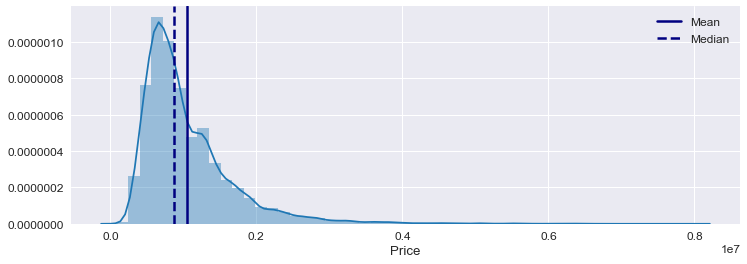

In [1282]:
means, medians = to_plot.mean(), to_plot.median()  
win_means, win_medians = to_plot_win.mean(), to_plot_win.median()

comparison = pd.DataFrame(np.column_stack([means, medians,
                                           (win_means - means), (win_medians - medians)]
                                          ),
                          columns = ['Mean', 'Median',
                                     'Δ Mean if winsorized', 'Δ Median if winsorized'],
                          index = means.index
                         )

price = train.Price[train.Price.notnull()]
mean = comparison.loc['Price', 'Mean']
median = comparison.loc['Price', 'Median']

sns.set_style('darkgrid')
sns.set(font_scale=1.2, palette='tab10')
plt.figure(figsize=(12,4))
sns.distplot(price)
plt.axvline(x=mean, color='navy', linewidth=2.5)
plt.axvline(x=median , color='navy', linestyle='--', linewidth=2.5)
plt.legend(['Mean', 'Median'])
plt.show()

The median is not only closer to that peak, but it’s also not affected by changes in extremes of the bell, as the middle value (the median) remains the same. That means that if we use the median we don’t need to worry about dealing with outliers when estimating the values that we’ll use to impute the data, the median wouldn’t change.

In [1283]:
comparison

,Mean,Median,Δ Mean if winsorized,Δ Median if winsorized
Rooms,3.031560e+00,3.000000,-0.011477,0.0
Price,1.051081e+06,870000.000000,-8419.226180,0.0
Distance,1.119487e+01,10.300000,-0.042564,0.0
Bathroom,1.628076e+00,2.000000,-0.003382,0.0
Car,1.731145e+00,2.000000,-0.014309,0.0
Landsize,5.954782e+02,521.000000,-92.199163,0.0
BuildingArea,1.619546e+02,136.000000,-7.706565,0.0
YearBuilt,1.965595e+03,1970.000000,0.085047,0.0
Lattitude,-3.781103e+01,-37.807755,0.000184,0.0
Longtitude,1.450016e+02,145.007600,0.000120,0.0


Last but not least, it makes more sense to use the median for the discrete variables as it will always return an already existing value. We don’t want to impute something like 2.387 cars e.g. but rather 2 cars.

## Create target variable

We want to find houses with more than three rooms, so we need to split the discrete variable _Rooms_ into a binary classification.

In [1284]:
# Transform discrete variable 'Rooms' into a categorical variable
for df in datasets:
    df['>3 Rooms'] = df['Rooms'].apply(lambda x: 1 if x > 3 else 0)
    df.drop('Rooms', axis=1, inplace=True)

## Plot continuous variables segmented by number or rooms 
Now that our data is binary labeled (0 =  _3 or less rooms_, 1 = _more than 3 rooms_) we want to look for differences in the distribution of the data between labels. Variables with a significant different in distribution between labels will be a good candidates to be included as model features.

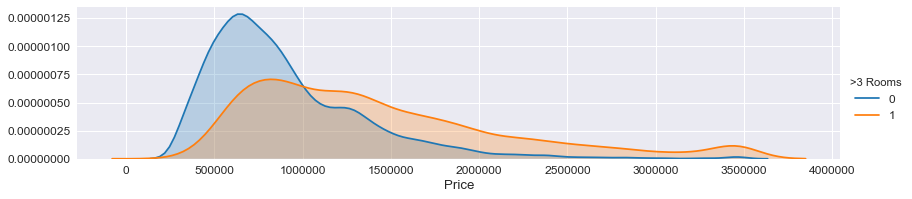

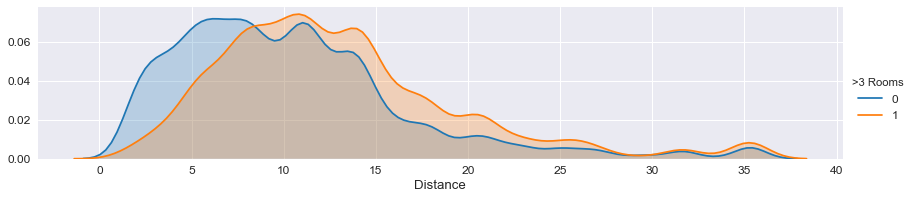

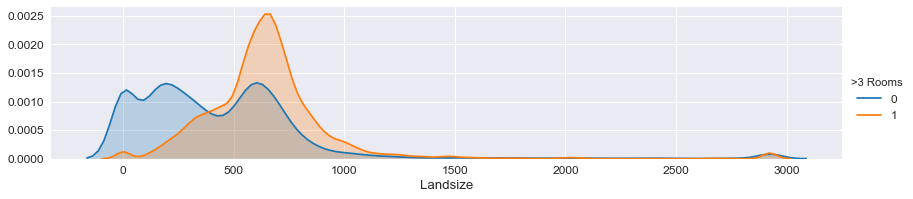

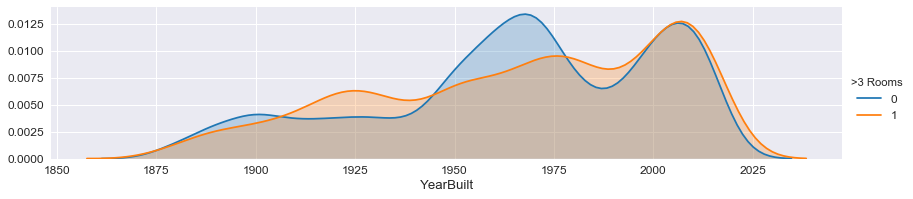

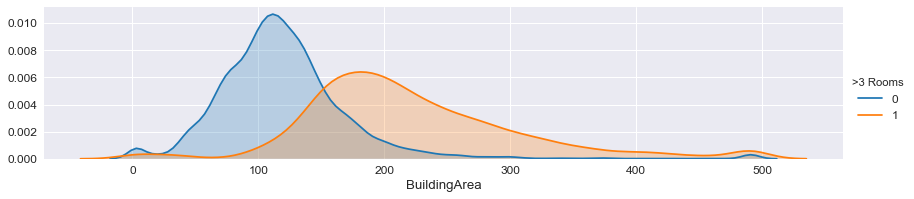

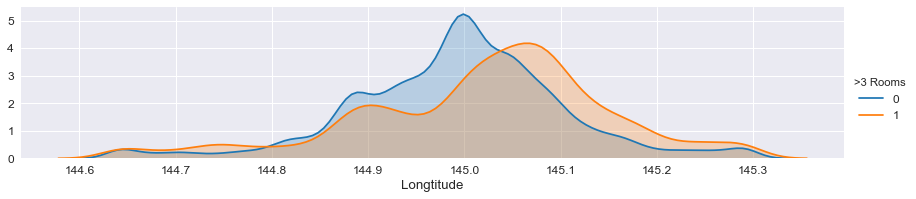

In [1285]:
to_plot_win['>3 Rooms'] = train['>3 Rooms']
cols = ['Price', 'Distance', 'Landsize', 'YearBuilt', 'BuildingArea', 'Longtitude']

sns.set(font_scale=1.2, palette='tab10')
for col in cols:
    g = sns.FacetGrid(to_plot_win, hue = '>3 Rooms', aspect=4 )
    g.map(sns.kdeplot, col, shade= True )
    x_min = to_plot_win[col].min()
    x_max = to_plot_win[col].max()
    g.add_legend()

Looking at the charts we obesrve that all variables except _YearBuilt_ show clear differences in distribution, particularly _BuildingArea_. If we want to dive deeper, running some t-tests can tell us if this differences are statistically significant _(to do in a future update)_.

In [1286]:
## Add count of discrete variables by target label

## Count unique values on  categorical variables

In [1287]:
# create list of categoric variables
categoric = list(train.select_dtypes(include=['object']).columns)
categorical = train[categoric]
categorical.nunique()

Suburb         345  
Address        27352
Type           3    
Method         9    
SellerG        365  
Postcode       209  
CouncilArea    33   
Regionname     8    
dtype: int64

Address is almost unique to every single sale. This means that not only has no predictive value but it will be very computationally intensive once transformed to dummy variables. We are going to drop it.

In [1288]:
for df in datasets:
    df.drop('Address', axis=1, inplace=True)

## Replace region names by acronyms
We’ll use acronyms to lighten labels and legends on some of the visualizations

In [1289]:
for df in datasets:
    df['Region'] = df['Regionname'].apply(
                                        lambda x: ''.join(e[0] for e in re.split(' |-', x))
                                             )
    df.drop('Regionname', axis=1, inplace=True)

## Explore categorical variables segmented by number or rooms

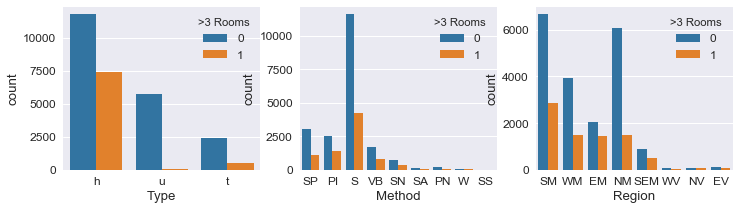

In [1290]:
cols = ['Type', 'Method', 'Region']

f, ax = plt.subplots(1,3, figsize=(12,3))
for col, ax in list(zip(cols, ax)):
    sns.countplot(x=col, hue='>3 Rooms', data=train, ax=ax)

Target labels are distributed in the train set approximately as:
* 70% sales labeled as _3 or less rooms_ 
* 30% sales labeled as _more than 3 rooms_.

However some of the independent variables labels clearly lean towards one specific output and hence will help us predict the target. For example anything labeled as type ‘u’ or ‘t’ is likely to have 3 or less rooms. We could also scale the count of all labels between 0-1 and see how the class distribution change _(to do in a future update)_.

## Create Day and Month variables
Intuitively the date of a sale and the number of rooms of that sale don't sound connected. In any case we’re going to create a day and month variables just to make sure that we can discard them.

In [1291]:
# Create new features for month and day
for df in datasets:
    df['Month'] =  df['Date'].apply(lambda x: x.month)
    df['Day'] =  df['Date'].apply(lambda x: x.dayofweek)

## Plot correlation matrix

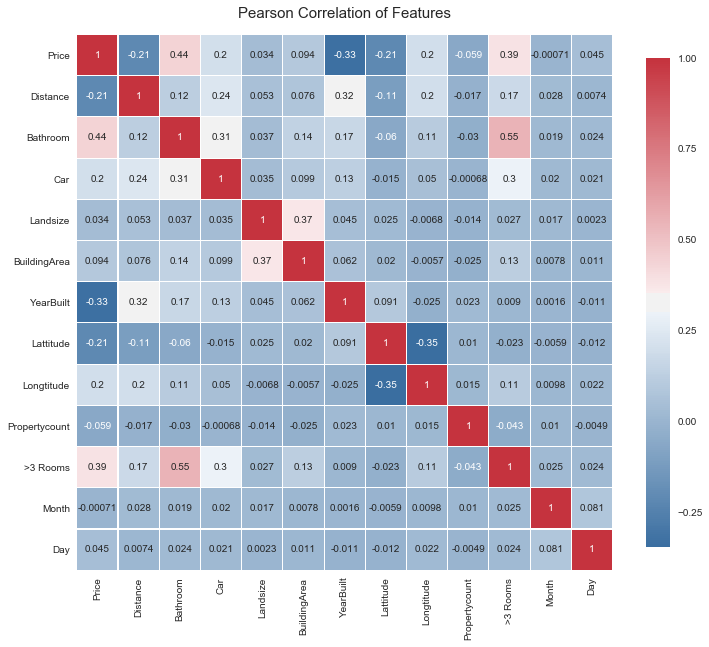

In [1552]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(12, 10))
    colormap = sns.diverging_palette(246, 10, s=76, l=45, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':10}
    )
    
    plt.title('Pearson Correlation of Features', y=1.02, size=15)

correlation_heatmap(train)

The matrix plots the correlation between numerical variables. These are the values pre-imputing the missing data and so not the final numbers that our imputed set would show, but should be close.

A number of variables are correlated to our target:
* __Bathroom__: As houses have more bedrooms they tend to have more bathrooms and overall more rooms.
* __Car__: more cars can be an indicator of more people living in the houses and more rooms.
* __Price__: as the price increases is more likely that the house will have more than 3 rooms
* __Distance__: The sq. feet price decreases as we move from downtown, so houses tend to be bigger and have more rooms
* __Building Area__: a higher building area means more space for rooms.
* __Longitude__: in many cities the north tends to be richer, and so bigger houses and more rooms.

Correlation doesn’t always mean causation, but again, the results do make sense so far.

Some of the variables are not only correlated to our target variable, but between them. We will go into this when we run our initial algorithms.

Also, though Landsize correlation to our target variable is low, there's was a clear diference below 400 approx. We could create a binary feature that separates sales by this specific landsize (_to do in a future update_).

## Plot pairplot of selected numerical variables segmented by target label
We will use the winsorized data and some jitter for visual purposes. This pairplot summarizes much of what we've already seen in the distribution of variables and correlation between them and by target label

In [1293]:
# Select variables correlated with target
numeric = ['Price', 'Distance', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Longtitude']
to_plot = to_plot_win[numeric + ['>3 Rooms']]

# Add jitter to discrete variables
vars_jittered = to_plot_win[['Bathroom', 'Car']]
jitter = pd.DataFrame(
                      np.random.uniform(-.3, .3, size=(vars_jittered.shape)),
                      columns=vars_jittered.columns
                     )
vars_jittered = vars_jittered.add(jitter)

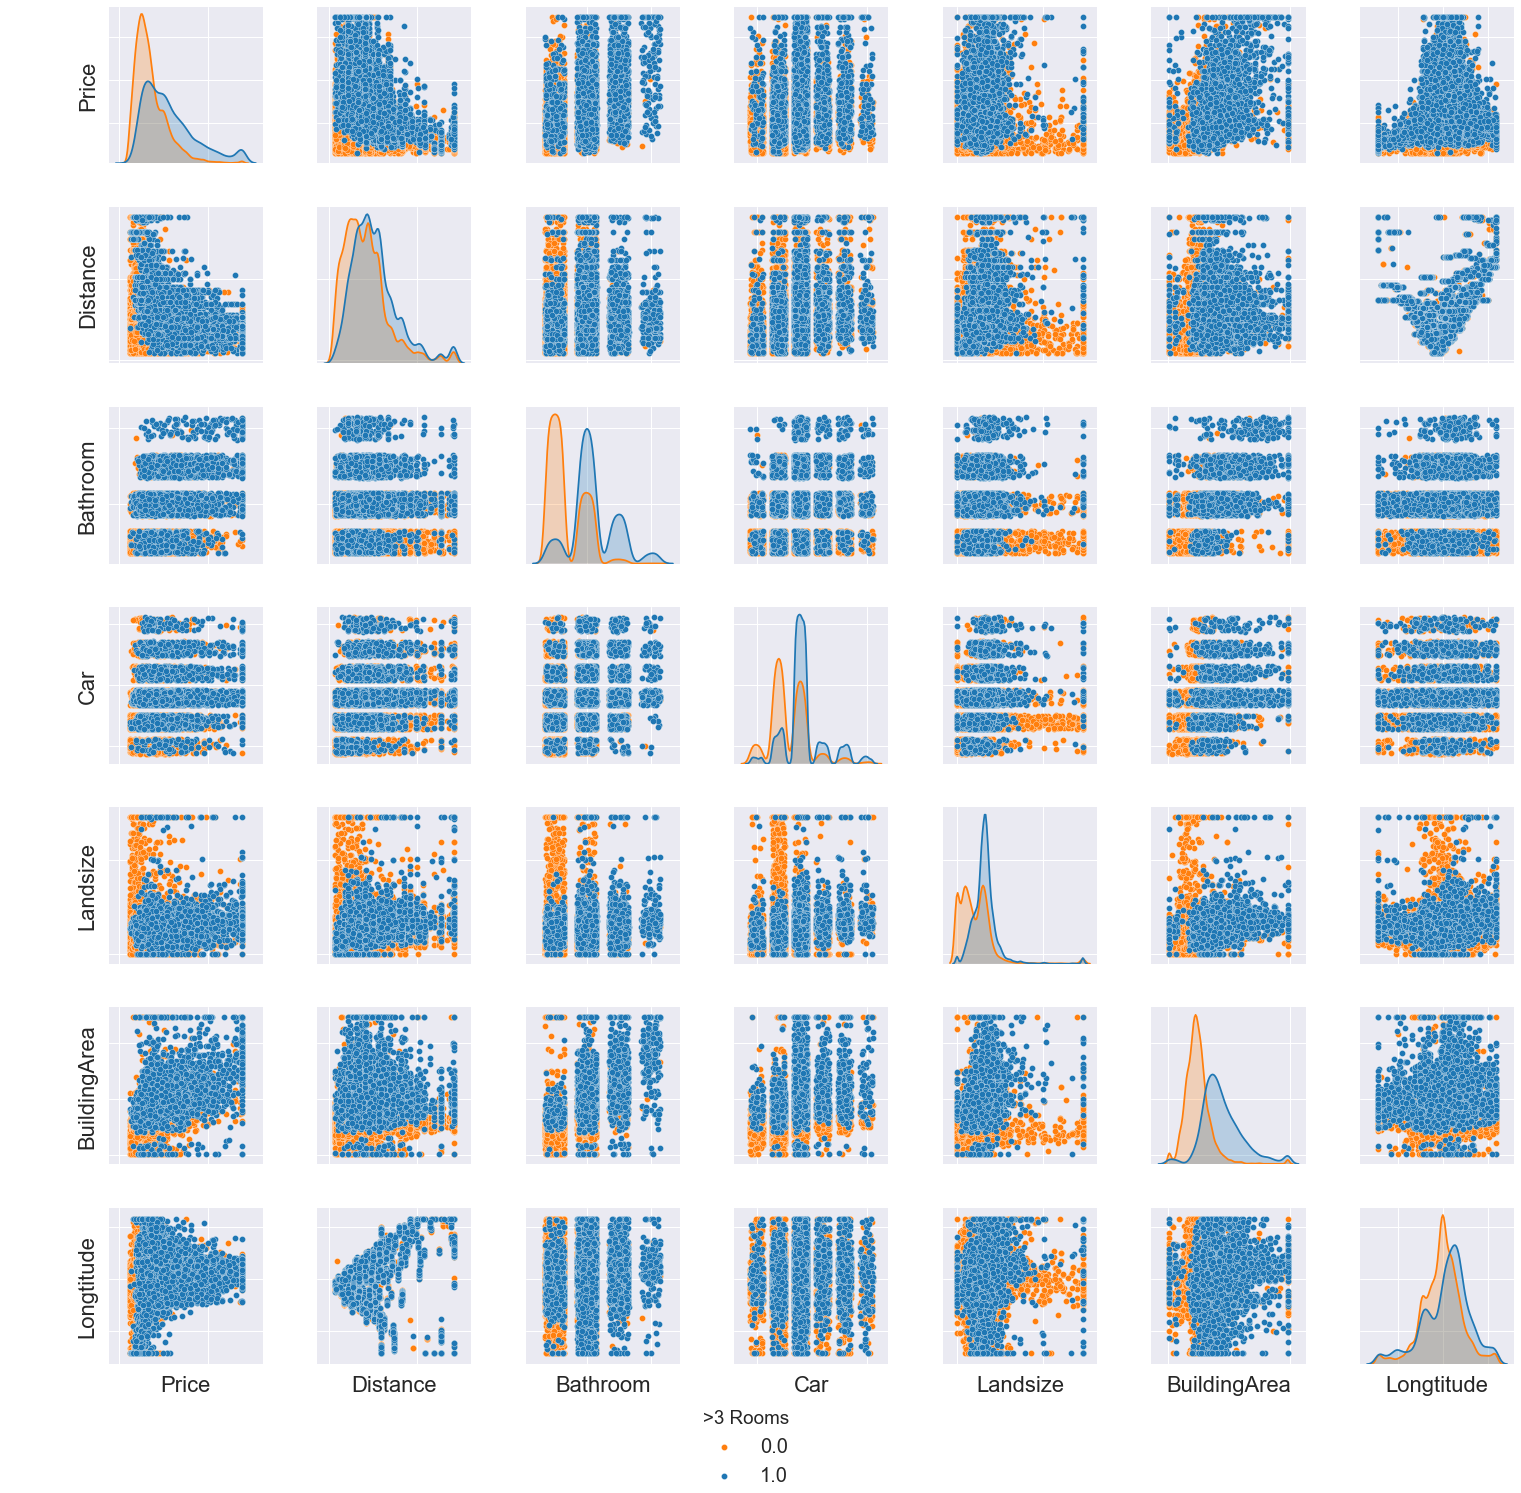

In [1589]:
inv_clrs = sns.color_palette("tab10")[:2][::-1]

# Create pairplot
sns.set_style('dark')
sns.set(font_scale=2)
pp = sns.pairplot(data=df_jittered, vars=numeric, hue='>3 Rooms', palette=inv_clrs, 
                  size=3, diag_kind='kde', diag_kws=dict(shade=True),
                  plot_kws=dict(s=150), markers='.',
                 )
pp.set(xticklabels=[], yticklabels=[])
pp.fig.get_children()[-1].set_bbox_to_anchor((0.5, 0.03))
pp.fig.subplots_adjust(bottom=0.08)

plt.show()

## Run initial comparison of algorithms
We’ll consider the following

__The goal__
* ___Binary target___: we need to use a classification model to predict which sales have 3 or more rooms.
* ___Precision, Recall trade-off___: we want to utilize our call-center to its capacity while avoid as many unnecessary calls as possible (false positives) to keep the cost of acquisition. The first part is the recall of our model while the second is the precision. In our case, we just want to maximize the precision while keeping the recall high enough to provide sufficient leads to our sales agents.

__The Data__
We can describe our data as
* ___Skewed___: many variables right-skewed instead of following a normal distribution
* ___Contains outliers___: few but very high values on some of the variables
* ___Presents multicollinearity___: some features are highly-correlated.

__The models__
Initially, we’re going to try three different models
* ___Logistic Regression___: doesn’t require to normalize data and works well with outliers. However, the multicollinearity across some variables could still be an issue. To optimize our algorithm we could try PCA to reduce dimensionality of highly-correlated variables, although using a penalty l1 can also help as it reduces the number of coefficients that we effectively use.
To avoid overfitting this regression can be regularized. A regularization penalizes complexity in our model, which might decrease the training score (know data) but increase results predicting the test data (new unseen data) which is our ultimate goal.
We’re going to compare the model without regularization, with an l1 penalty (lasso regression), and white an l2 penalty (ridge regression). l1 is less sensitive to outliers and so it might work better in this case. 
* ___Random Forest___: Given some of the issues that we just described with the data, we will use Random Forest (RF). Unlike many other models, RF don’t make any assumptions on the distribution of the data and the relationship between variables, which means that we won’t need to perform any transformations. Also, because is made out of random trees we avoid easily overfitting.

__df length__
We are going to compare the results between a smaller dataframe with no missing data and a larger dataframe where we will impute using the median those missing values.



In [1295]:
def array_to_df(array, df):
    return pd.DataFrame(data=array,
                                  columns=df.columns,
                                  index=df.index
                                 )

In [1296]:
rfc = ensemble.RandomForestClassifier(random_state=13)
lrc = LogisticRegression(C=1e9, random_state=13)
lrc_l1 = LogisticRegression(penalty='l1', random_state=13)
lrc_l2 = LogisticRegression(penalty='l2', random_state=13)
models = {'LR l1': lrc_l1, 'LR l2': lrc_l2, 'RF': rfc}
scoring = {'Accuracy': 'accuracy', 'Precision': 'precision', 'Recall': 'recall', 'f1': 'f1'}

categoric = list(train.select_dtypes(include=['object']).columns)
features = numeric + categoric
imputing_levels = ['Impute', 'Drop']

results = []
for level in imputing_levels:
    # Drop or impute missing values
    imp = Imputer(missing_values='NaN', strategy='median', axis=0)
    if level == 'Impute':
        imp.fit(train[numeric])
        imputed = array_to_df(imp.transform(train[numeric]), train[numeric])
        train_ = pd.concat(objs=[train[categoric + ['>3 Rooms']], imputed], axis=1)
    else:
        train_ = train.dropna()
            
    X_train, y_train = train_[features], train_['>3 Rooms']
    X_train = pd.get_dummies(X_train)

    for name, model in models.items():  
        scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
        run_time = scores['fit_time'].sum() + scores['score_time'].sum()
        train_accy = scores['train_Accuracy'].mean()
        test_accy = scores['test_Accuracy'].mean()
        s_dev = scores['test_Accuracy'].std()*2
        precision = scores['test_Precision'].mean()
        recall = scores['test_Recall'].mean()
        f1 = scores['test_f1'].mean()

        results.append([name, level, len(X_train), run_time, train_accy, test_accy,
                        s_dev, precision, recall, f1])

In [1297]:
results = pd.DataFrame(results,
                       columns=['Classif.', 'NaN Imputed', 'df Length', 'RunTime',
                                'Train Accuracy', 'Test Accuracy', 'Deviation',
                                'Precision', 'Recall', 'f1']
                      )

cmp = sns.light_palette('MediumAquaMarine', as_cmap=True)
results.style.background_gradient(cmap=cmp)

,Classif.,NaN Imputed,df Length,RunTime,Train Accuracy,Test Accuracy,Deviation,Precision,Recall,f1
0,LR l1,Impute,27883,17.3853,0.837993,0.825808,0.00661334,0.730575,0.621577,0.671574
1,LR l2,Impute,27883,15.3322,0.756294,0.756376,0.0322146,0.768778,0.215364,0.327615
2,RF,Impute,27883,20.6739,0.986578,0.823907,0.0041032,0.744816,0.586536,0.656237
3,LR l1,Drop,7086,4.36354,0.863216,0.840954,0.0198477,0.774354,0.711013,0.741251
4,LR l2,Drop,7086,1.35515,0.820526,0.821339,0.0133606,0.807938,0.580176,0.675056
5,RF,Drop,7086,3.04024,0.99051,0.834179,0.0125259,0.78,0.671806,0.7218


__ Results by level of imputation__
All algorithms perform better dropping all missing values (particularly significant when using a l2 penalty) . As we’ve discussed before, this is not a practical approach to us, as we wouldn’t be able to analyze most future sales. Dropping these values also increases the variance, as expected.

__ Results by algorithm__
Let’s focus on the results when imputing the data.

* ___Logistic Regression l1___ doesn’t seem to overfit the data given the small difference between train and test set. It also has a good balance between precision and recall. Overall it performs better than the l1 penalization with or without imputed data. This can be due to its sparsity that can fight overfitting and collinearity among dependent variables and it’s tolerance to outliers.

* ___Logistic Regression l2___ it scores a high precision, but very poor recall. It’s basically labeling almost all values to the majority class. That’s why the test accuracy (0.75) is so close to the real distribution of data (approx. 71%). It has a very low performance. This happens when we impute the data, which raise a warning on how are we imputing and the impact it can have.

* ___Random Forest___ performance it’s pretty close to log. reg. l1. Has slightly more precision, lower recall and variance. The difference between train and test results is much higher, though still reasonable and we know, random forest are hard to overfit.
We will discard l2 penalty and focus on RF and log. reg. l1.

## Goal: Maximizing sales resources
The data set cover a span of 2.6 yers. In that time 35k houses have been sold, which averages around 36 sales a day and almost 250 a week. Class distribution is 29% for houses with more than 3 rooms, 71% for the rest. This reduces our potential leads to a total of 10k over the 2.6 years.

We have one sales-agent dedicated one day a week to Melbourne, 43 weeks a year. In that day he has capacity to an average of 44 calls. In the 2.6 years he could have done a little more than 5k calls.

That’s still half the number of all potential leads, so there are more houses in our segment that we can contact. The problem though is that houses with more than 3 rooms are a clear minority. If we randomly pick numbers we can expect to only contact 1450 potential leads out of those 5070 calls, which is clearly not efficient.
We want to maximize our agent's time increasing as possible the proportion of truepotential leads out in that total of 5070 calls. That will require tuning different aspects of our model to balance precision (avoiding false positives) and recall (avoiding false negatives).

These calculations are static and based on the current data, but we could also create a model that adjusts to the level of data that enter the system. If on a given week sales increase a lot we have more room to be precise, while on times of low activity we might want to increase recall. We can do so by adjusting the decision threshold of our model.

In [1298]:
days = (data.Date.max() - data.Date.min()).days
data_total_sales = len(data)
data_daily_sales = sales / days
class_distribution = len(data.Rooms[data.Rooms > 3]) / len(data)
agent_total_calls = (days /365) * 43 * 44
agent_total_leads = agent_total_calls * class_distribution

print('Total sales in df: ', data_total_sales)
print('Days: %d, Years: %.2f'%(days, days/365))
print('Agent expected total calls: %d, and leads: %d'%(agent_total_calls, agent_total_leads))

Total sales in df:  34857
Days: 979, Years: 2.68
Agent expected total calls: 5074, and leads: 1450


## Tune level of imputation
We know that by dropping rows with missing data, we lose all the information of the existing fields in that row and we increase the variance as our sample is smaller. We also reduce the number of sales we can predict in the future. By imputing data however, we’re introducing error which also affects the accuracy, precision, etc. If a sale has many missing fields and we’re imputing those fields with the variable mean, that has very informational value and it’s easy to introduce confusion to the model. We’re going to see how our model performs if we start dropping more and more missing data. First we’ll get rid of rows with all numeric missing fields, and increase that threshold. As we do so, we’ll have less data. The goal is to find a sweet spot where we increase results without giving up to too many sales. Again, the idea is to provide our call center with enough calls in the future and avoiding as possible false positives.
When doing this exercise, we don’t necessarily want to pick what returns the highest accuracy but maximize precision while getting enough leads for the call-center.

In [1299]:
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
scoring_2 = {'Accuracy': 'accuracy', 'Precision': 'precision', 'Recall': 'recall', 'f1': 'f1',
             'tp' : make_scorer(tp), 'fp' : make_scorer(fp)}

models = {'LR l1': lrc_l1, 'RF': rfc}
results_drop = []
for threshold in range(1,8):
    train_ = train.dropna(thresh=threshold, subset=numeric)
    X_train_, y_train_ = train_[features], train_['>3 Rooms']
    imp.fit(X_train_[numeric])
    imputed = array_to_df(imp.transform(X_train_[numeric]), X_train_[numeric])
    X_train_ = pd.concat(objs=[X_train_[categoric], imputed], axis=1)
    X_train_ = pd.get_dummies(X_train_)
    
    for name, model in models.items():  
        scores = cross_validate(model, X_train_, y_train_, cv=5, scoring=scoring_2)
        test_accy = scores['test_Accuracy'].mean()
        precision = scores['test_Precision'].mean()
        recall = scores['test_Recall'].mean()
        tp_ = scores['test_tp'].sum()
        fp_ = scores['test_fp'].sum()

        results_drop.append([name, threshold, len(X_train_), test_accy,
                             precision, recall, tp_, fp_]
                               )
        
results_drop = pd.DataFrame(results_drop,
                            columns=['Classifier', 'Threshold', 'df Length', 'Test Accuracy',
                                     'Precision', 'Recall', 'True Positives', 'False Positives']
                      )

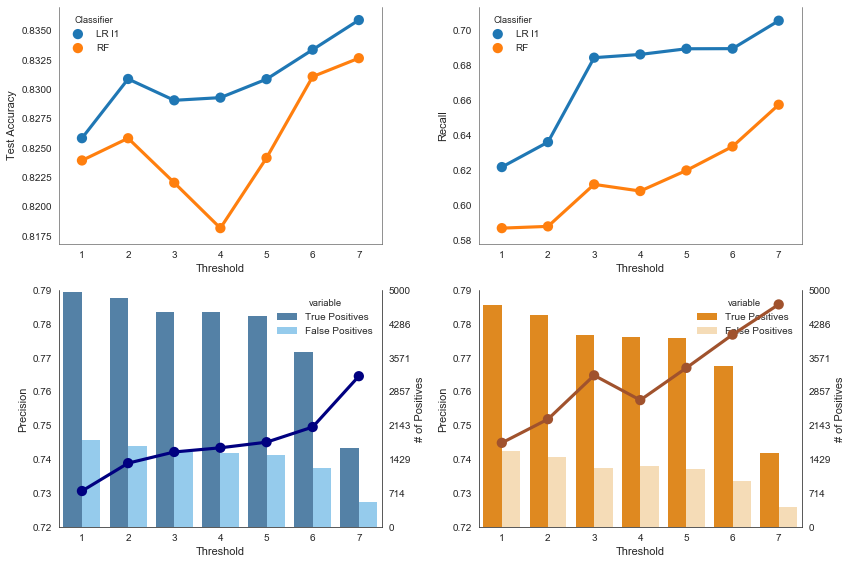

In [1625]:
to_melt = results_drop[['Classifier', 'True Positives', 'False Positives', 'Threshold']]
results_melt = pd.melt(to_melt, id_vars=['Classifier', 'Threshold'])
pltte = ['steelblue', 'darkorange', 'lightskyblue', 'navajowhite']

sns.set(font_scale=1, palette='tab10')
sns.set_style('white', {'axes.linewidth': 0.5})
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.pointplot(x='Threshold', y='Test Accuracy', hue='Classifier', data=results_drop)

plt.subplot(222)
sns.pointplot(x='Threshold', y='Recall', hue='Classifier', data=results_drop)

ax1 = plt.subplot(223)
ax2 = ax1.twinx()
sns.pointplot(x='Threshold', y='Precision', color='navy',
              data=results_drop[results_drop.Classifier == 'LR l1'], ax=ax1)
sns.barplot(x='Threshold', y='value', hue='variable', palette=pltte[::2], ax=ax2,
            data=results_melt[results_melt.Classifier == 'LR l1'])
ax1.set_zorder(10)
ax1.patch.set_visible(False)
ax1.set_ylim([.72, .79])
ax2.set_ylim([0, 5000])
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
ax2.set_ylabel('# of Positives')


ax3 = plt.subplot(224)
ax4 = ax3.twinx()
sns.pointplot(x='Threshold', y='Precision', color='sienna',
              data=results_drop[results_drop.Classifier == 'RF'], ax=ax3)
sns.barplot(x='Threshold', y='value', hue='variable', palette=pltte[1::2], ax=ax4,
            data=results_melt[results_melt.Classifier == 'RF'])
ax3.set_zorder(10)
ax3.patch.set_visible(False)
ax3.set_ylim([.72, .79])
ax4.set_ylim([0, 5000])
ax4.set_yticks(np.linspace(ax4.get_yticks()[0], ax4.get_yticks()[-1], len(ax3.get_yticks())))
ax4.set_ylabel('# of Positives')

plt.tight_layout()
sns.despine(right=False, left=False)
plt.show()

Adjusting the threshold to three (dropping every row that contains data for less than three of the numerical variables) seems to find a sweet spot between precision and recall, even though overall accuracy my drop slightly.

In [1305]:
# drop rows above threshold
train_adjstd = train.dropna(thresh=3, subset=numeric) 
test_adjstd = test.dropna(thresh=3, subset=numeric)

# impute remaining missing values with median
imp.fit(train_adjstd[numeric])
imputed = array_to_df(imp.transform(train_adjstd[numeric]), train_adjstd[numeric])
train_imputed = pd.concat(objs=[train_adjstd[categoric + ['>3 Rooms']], imputed], axis=1)

## Tune feature selection
Feature selection affects the model results but also run time. Categorical variables with a high number of classes produce high-dimensional features once we convert those to variables and are computational more intensive. This is more noticeable for Random Forest as it’s more complex.

We want to see what features account more in the prediction and try different combinations.

All numerical variables are more important than any of the categorical variables. This are also the variables were missing values are present, which is a challenge. Looking at the Random Forest ranking, Type and Method also seem to be significant. This goes in line with what we already observed when we segmented class count for categorical variables using our target and we saw some clear differences between class and global distribution.

The graph clearly shows how the logistic regression coefficients are very sparse in comparison to the Random Forest as result of the regularization penalty.

We’re now going to run our algorithms with different sets of features and compare:


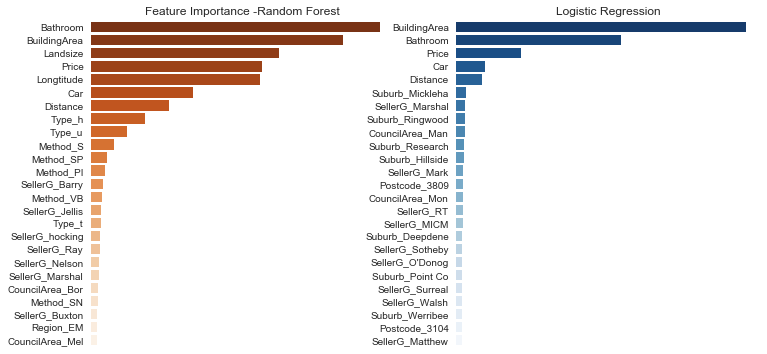

In [1594]:
sns.set_style('white', {'axes.linewidth': 0})

X_train_imp = train_imputed[features]
y_train = train_imputed['>3 Rooms']
X_train_dum = pd.get_dummies(X_train_imp)

rfc.fit(X_train_dum, y_train)
lrc_l1.fit(X_train_dum / np.std(X_train_dum, 0), y_train)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
for ax in (ax1, ax2):
    rank = pd.DataFrame(rfc.feature_importances_ if ax is ax1 else lrc_l1.coef_[0],
                        index = X_train_dum.columns.str.slice(0,15),
                        columns=['importance']).sort_values('importance', ascending=False)
    ax.set_title('Feature Importance -' +
                 'Random Forest' if ax is ax1 else 'Logistic Regression')
    sns.barplot(x='importance', y=rank.index[:25], data=rank[:25], ax=ax,
                palette='Oranges_r' if ax is ax1 else 'Blues_r')
    ax.set_xticks([])
    ax.set_xlabel('')

In [1307]:
feat_selections = {'All features': features,
                   'Only numerical': numeric,
                   'Only categorical': categoric,
                   'Mix features': numeric + ['Type', 'Method']}

results_feat = []

for selection_name, feats in feat_selections.items():
    X_train_feat = X_train_imp[feats]
    X_train_feat = pd.get_dummies(X_train_feat)

    for name, model in models.items():
        scores = cross_validate(model, X_train_feat, y_train, cv=5, scoring=scoring)
        accy = scores['test_Accuracy'].mean()
        precision = scores['test_Precision'].mean()
        recall = scores['test_Recall'].mean()
        run_time = scores['fit_time'].sum() + scores['score_time'].sum()
        results_feat.append([name, selection_name, accy, precision, recall, run_time])

results_feat = pd.DataFrame(results_feat,
                           columns=['Classifier', 'Selection', 'Accuracy',
                                    'Precision', 'Recall', 'Time']
                          )
results_feat_styled = results_feat.style.background_gradient(cmap=cmp)
results_feat_styled

,Classifier,Selection,Accuracy,Precision,Recall,Time
0,LR l1,All features,0.82904,0.742121,0.684369,8.26769
1,RF,All features,0.822006,0.764771,0.611651,12.9375
2,LR l1,Only numerical,0.816975,0.761376,0.593544,0.862626
3,RF,Only numerical,0.830438,0.764582,0.65148,2.04767
4,LR l1,Only categorical,0.727489,0.588312,0.391219,6.85498
5,RF,Only categorical,0.696697,0.510986,0.413703,18.9403
6,LR l1,Mix features,0.825174,0.745105,0.659929,0.731035
7,RF,Mix features,0.832907,0.766325,0.660384,2.09394


The results with only categorical variables are not better than random. The logistic regression obtain the best combination of precision and recall selecting all features, while Random Forest obtains better results with a mix of numerical and categorical features.


Let’s look at the results at this point for both algorithms and their corresponding feature selections. 

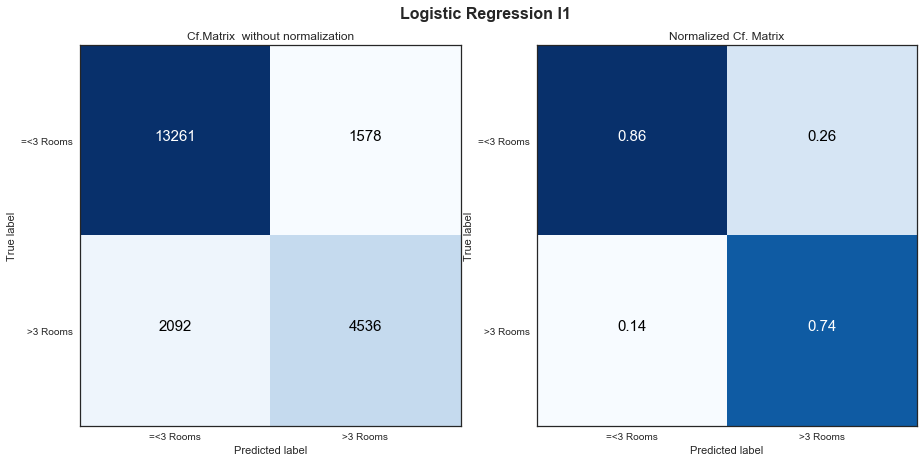

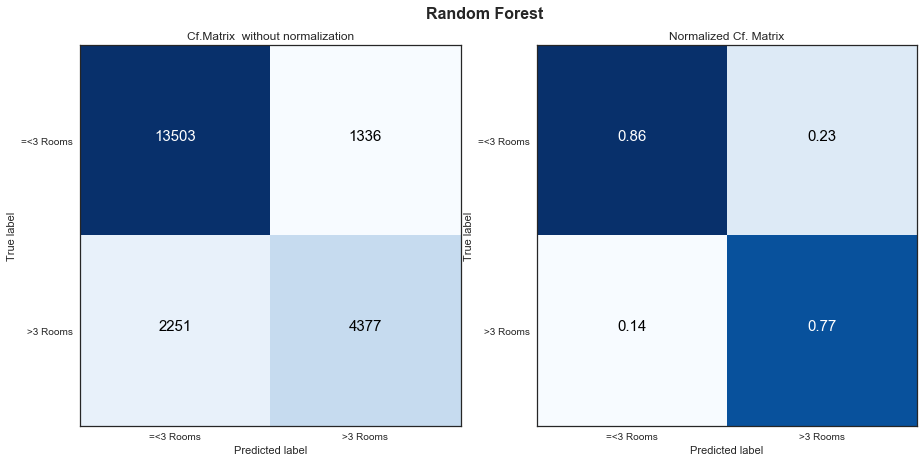

In [1308]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks), ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=15)

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

X_train_mix = X_train_imp[feat_selections['Mix features']]
X_train_mix = pd.get_dummies(X_train_mix)

# Confusion matrix scoring
conf_scoring = {'tn' : make_scorer(tn), 'fp' : make_scorer(fp),
                'fn' : make_scorer(fn), 'tp' : make_scorer(tp)}

# Compute and plot confusion matrix 
sns.set_style('white')
for df in (X_train_dum, X_train_mix):
    cv_results = cross_validate(lrc_l1 if df is X_train_dum else rfc,
                                df, y_train, cv=5, scoring=conf_scoring)
    tn_, fp_ = cv_results['test_tn'].sum(), cv_results['test_fp'].sum() 
    fn_, tp_ = cv_results['test_fn'].sum(), cv_results['test_tp'].sum()
    cnf_matrix = np.array([[tn_, fp_],[fn_, tp_]])
    np.set_printoptions(precision=2)
    class_names = ['=<3 Rooms', '>3 Rooms']

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
    for ax in (ax1, ax2):
        plot_confusion_matrix(cnf_matrix, classes=class_names,
                              normalize=True if ax == ax2 else False,
                              title=('Normalized Cf. Matrix' if ax == ax2 else 
                                     'Cf.Matrix  without normalization')
                             )
    plt.suptitle('Logistic Regression l1' if df is X_train_dum else 'Random Forest',
                y=0.9, fontsize=16, fontweight='bold')
    plt.show()

Random Forest has a slightly higher precision. In both cases false and true positives are above our limit (5070) which means we would still have margin to tweak our decision threshold and lower our recall but increase precision. That means that instead of assuming that anything with probability above 0.5 is class 1, increase that bar. We will have more false negatives, but the sales identified as true are more likely to be true.

## Tune imputation of data
So far we’ve used each variable median to impute missing values. We’ve already explained some of the advantages/disadvantages of this method.

The percentage of missing data is high, especially on Building Area which tends to be a great predictor but is missing in more than half of the cases. For these reasons we want to try other ways to impute the data and see if any can provide a clear advantage.

### Explore region and postcode variables
Some categorical variables have a geographical component and are linked to a latitude and longitude area. We can clearly see this in the image below for Region and Postcode. 

Code to create maps [here](http://localhost:8888/notebooks/Desktop/thinkful/capstone%20-%20supervised%20learning/Melbourne%20Housing%20Market%20-%20Create%20maps.ipynb)

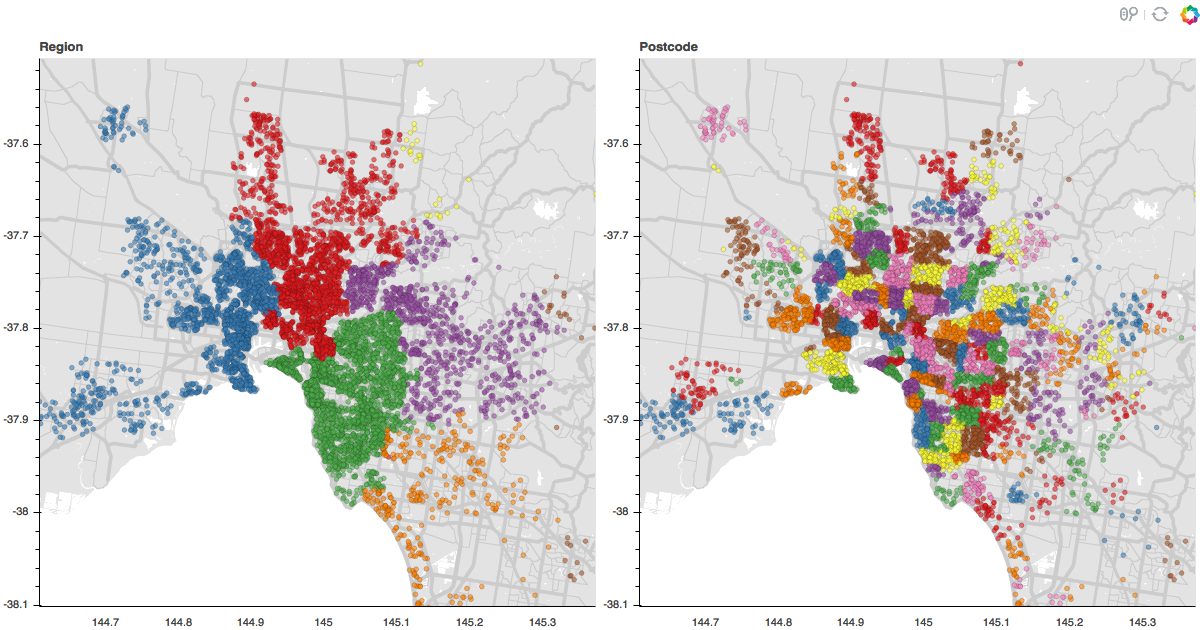

In [1309]:
from IPython.display import Image
Image('Sales_by_Region_and_Postcode.png')

If we know the region we can narrow the longitude and latitude, and even further with the postcode. Instead of taking the median of the entire variable we group by any of these variables. If we really wanted to go deep we could probably use the street to find the exact latitude and longitude through google maps.

We can not only use these groups to impute the longitude, but other variables. One thing that clearly changes is the sample size used to calculate the median in each option.

* __Sample size for variable median__: train set length * level of complete data
* __Sample size for median grouped by region__: average of → train set length * level of complete data / 8 regions
* __Sample size for median grouped by postcode__: average of → train set length * level of complete data / 211 postcode

So the sample we’re using to calculate a postcode is going to be on average 211 smaller than the variable median. And that’s the average, there’s a huge range of postcodes by number of sales. This differences in size affect the relationship between bias and variance in our imputation. We can expect our imputation with the variable median to underfit (it’s missing some of the relevant relations) while using the postcodes might overfit (It’s capturing noise in the train set).

Another problem is that as we segment more and more the data into groups, we increase the risk of having in the future a new group not included in the train set. However in that case we can always scale a level up and assign the group or the variable value.

With that said, let’s check if we can see some clear difference by variable and group. Let’s start with the different regions.


### Explore differences by Region

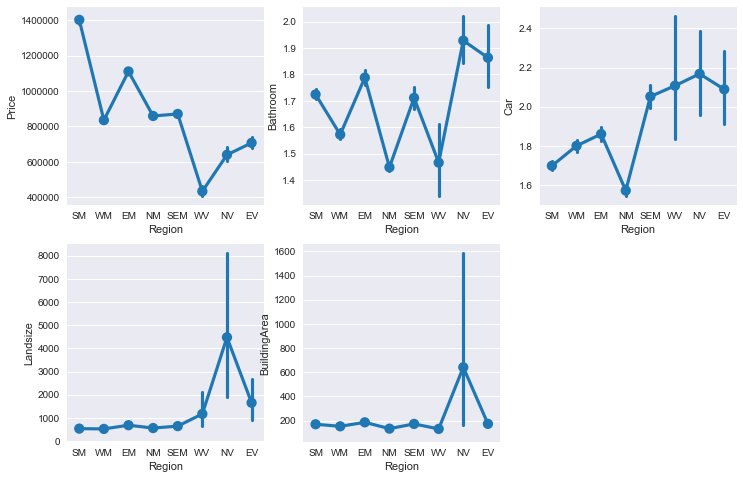

In [1310]:
sns.set_style('darkgrid')

# Select columns that have NaN values (excluding longt. and latt.)
to_plot = train[train.columns[train.count() < len(train)].drop(['Longtitude', 'Lattitude'])]
to_plot['Region'] = train['Region']

# See if region differences are significant on variables with missing values
plt.figure(figsize=(12,8))
cols = to_plot.columns.drop('Region')
subplot_num = range(1, len(cols))
for col, number in list(zip(cols, subplot_num)):
    plt.subplot(230 + number)
    sns.pointplot(x='Region', y=col, data=to_plot)

We can appreciate clear differences from region to region. That couple with a small error bar is a good sign. Seems to be the case for price for example. Others like Bathroom and Car show more uncertainty and in the case of Landsize and BuildingArea some outliers seem to be impacting the results for the North Victoria region.

### Explore differences by Postcode
Let’s look at how sales are distributed by Postcode and variable. We’re only going to focus on continuous variables.

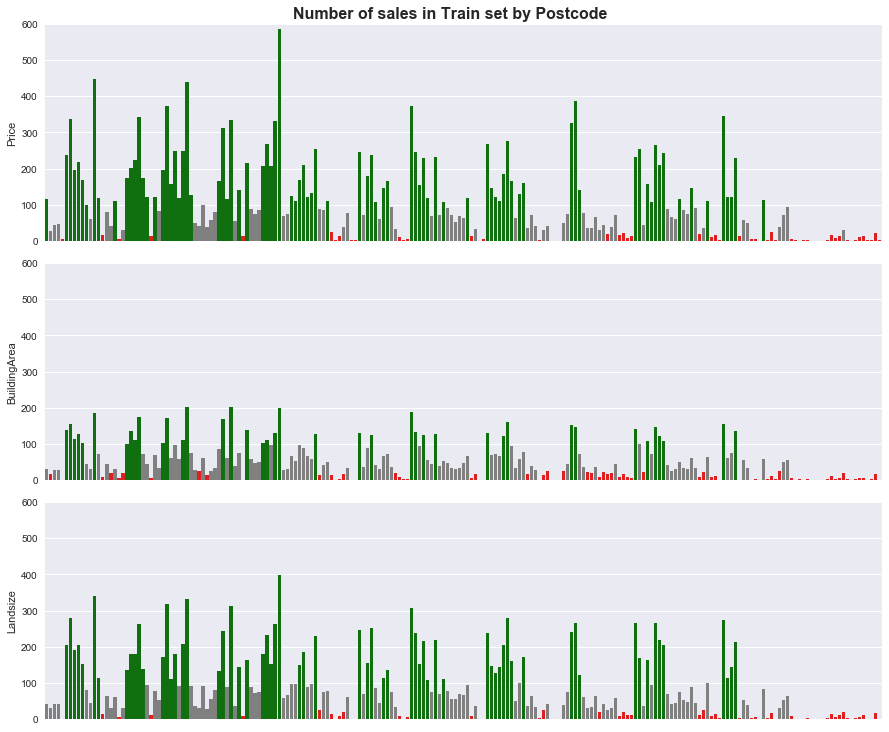

In [1319]:
zip_cols = ['Price', 'BuildingArea', 'Landsize']
zip_count = train.groupby(['Postcode']).count()[zip_cols]
zip_count.reset_index(inplace=True)

sns.set_style('darkgrid')
f, ax = plt.subplots(3,1, figsize=(15,12))
plt.suptitle('Number of sales in Train set by Postcode', y=0.95,
             fontsize=16, fontweight='bold')
for col, ax in list(zip(zip_cols, ax)):
    colors = list(zip_count[col].apply(
            lambda x: 'green' if x > 100 else 'grey' if x > 25 else 'red'))
    sns.barplot(x='Postcode', y=col, data=zip_count, ax=ax, palette=colors)
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylim([0,600])
f.subplots_adjust(top=0.93, hspace=0.1)
plt.show()

In [1312]:
for col in zip_cols:
    below_10 = zip_count[col][zip_count[col] < 5].count()
    percentage = round(below_10/len(zip_count)*100, 2)
    print(col, below_10, percentage, '%' )

Price 28 13.4 %
BuildingArea 37 17.7 %
Landsize 32 15.31 %


There are very significant differences. Some postcodes register many sales while other little or none. The less sales the less representative that the postcode might be (more variance). About 13-17% of postcodes have less than 5 entries. Also, notice that as the level of missing data is much more accute for BuildingArea we have in general much less sales by postcode, which will probably increase the error of the mean or median.

Now, as we did with the region, we want to see the differences in mean (in color by region) and median (in white).

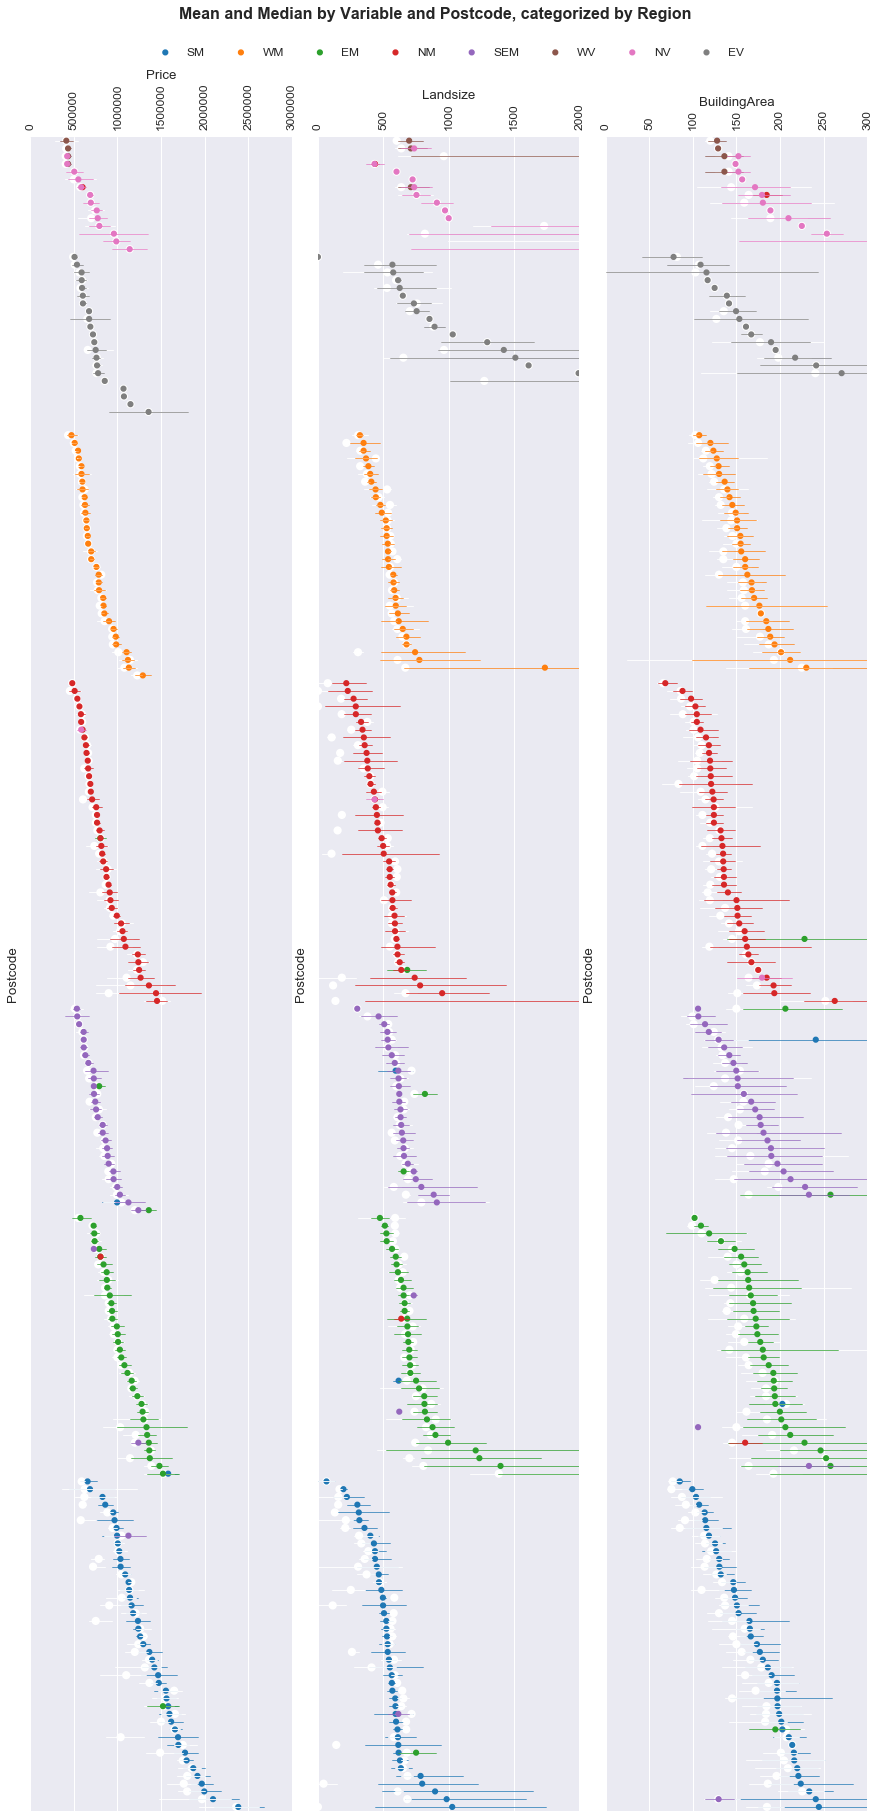

In [1339]:
region_mean = train.groupby(['Region']).mean()['Price'].sort_values()
postcode_mean = train.groupby(['Region', 'Postcode']).mean()
postcode_mean.reset_index(inplace=True) 
postcode_mean['Region mean'] = postcode_mean['Region'].apply(lambda x: region_mean[x])
zip_cols = ['Price', 'Landsize', 'BuildingArea']

sns.set(font_scale=1.2)
f, ax = plt.subplots(1,3, figsize=(15,30))
plt.suptitle('Mean and Median by Variable and Postcode, categorized by Region',
             y=0.96, fontsize=16, fontweight='bold')

for col, ax in list(zip(zip_cols, ax)):
    order = postcode_mean.sort_values(['Region mean', col])['Postcode']
    
    sns.pointplot(x=col, y='Postcode', data=train, order=order, orient='h', color='w',
                  estimator=np.median, join=False, ax=ax, scale=.8, errwidth=.9)
    sns.pointplot(x=col, y='Postcode', data=train, hue='Region', order=order, orient='h',
                  join=False, ax=ax, scale=.6, errwidth=.7, palette='tab10', legend_out=True)
    
    ax.set_yticklabels([])
    ax.tick_params(axis='x', rotation=90)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') #tweak this
    ax.set_xlim(0, 3e6 if col is 'Price' else 2000 if col is 'Landsize' else 300)
    if col is 'Landsize':
        ax.legend(loc='upper center', ncol=8, bbox_to_anchor=(0.5, 1.06),
                  shadow=True)
    else:
        ax.legend().set_visible(False)
        
f.subplots_adjust(top=0.9, wspace=0.1)
plt.show()

As samples reduce outliers influence increase. Again we want to compare the differences in mean, median vs the error to see if it could be significant. Prices again shows values closer to their mean, median.

Notice that postcodes are not aligned between charts, but sorted individually by region and mean in each case. Some outliers are cut-off to keep the detail.

We’re not including data from the test set to calculate the medians and avoid data leakage. Technically we should do the same thing when running the cross validation on our train set, but since we have a final sanity check with our test set, we’ll skip that.

### Test different imputation methods

In addition to grouping a variable median by another variable (like region or postcode), there are other imputing models out there. KNN neighbors and MICE are some popular ones. We won’t try for the moment KNN neighbors as it has proven too computationally extensive on my current machine and dataset, but maybe in the future.

In [57]:
def impute_by_group(df, grouper): #Improve codes with less than x results
    imp_df = df.copy()
    for col in use_median:
        var = imp_df[col].values
        region = imp_df['Region'].values
        zip_c = imp_df['Postcode'].values
        if grouper is 'Postcode':
            imp_df[col] = np.where(np.isnan(var), medians_zip.loc[zip_c, col], var)
        imp_df[col] = np.where(np.isnan(var), medians_region.loc[region, col], var)
    return imp_df

In [58]:
use_median = train_adjstd[features].columns[train_adjstd[features].isna().any()]
medians_zip = train_adjstd[features].groupby('Postcode').median()[use_median]
medians_region = train_adjstd[features].groupby('Region').median()[use_median]

# Impute median by Region
X_train_region = impute_by_group(train_adjstd[features], 'Region')

# Impute median by Postcode
X_train_zip = impute_by_group(train_adjstd[features], 'Postcode')

# Impute using MICE algorithm
encode = train_adjstd[features].drop(numeric, axis=1)
encode = encode.apply(LabelEncoder().fit_transform)
X_train_mice = pd.concat(objs=[train_adjstd[numeric], encode], axis=1 )
X_train_mice = array_to_df(MICE(n_imputations=200, impute_type='col',
                              verbose=False).complete(X_train_mice),
                         X_train_mice,
                        )

X_train_mice = pd.concat(objs=[train_adjstd[categoric], X_train_mice[numeric]], axis=1)

imputations = {'no group': X_train_imp, 'by Region': X_train_region, 'by Postcode': X_train_zip, 'MICE': X_train_mice}

In [59]:
models = {'Log. Regression l1': lrc_l1, 'Random Forest': rfc}
imp_results = []
for imp_type, X_train_imp_ in imputations.items():
    X_train_imp_ = pd.get_dummies(X_train_imp_)
    for name, model in models.items():
        scores = cross_validate(model, X_train_imp_, y_train, cv=5, scoring=scoring)
        test_accy = scores['test_Accuracy'].mean()
        confidence = scores['test_Accuracy'].std()*2
        precision = scores['test_Precision'].mean()
        recall = scores['test_Recall'].mean()

        imp_results.append([name, imp_type, test_accy, confidence, precision, recall])

imp_results = pd.DataFrame(imp_results,
                           columns=['Classifier', 'Imputation', 'Test Accuracy',
                                    '+/- var. 95% CI', 'Precision', 'Recall']
                          )

imp_results

,Classifier,Imputation,Test Accuracy,+/- var. 95% CI,Precision,Recall
0,Log. Regression l1,no group,0.825808,0.006613,0.730575,0.621577
1,Random Forest,no group,0.823907,0.004103,0.744816,0.586536
2,Log. Regression l1,by Region,0.827027,0.007613,0.730908,0.627707
3,Random Forest,by Region,0.822185,0.006203,0.742572,0.581155
4,Log. Regression l1,by Postcode,0.828031,0.008768,0.730073,0.634841
5,Random Forest,by Postcode,0.821576,0.003119,0.740816,0.580654
6,Log. Regression l1,MICE,0.824230,0.006281,0.724063,0.625081
7,Random Forest,MICE,0.818169,0.010958,0.743484,0.558130


MICE imputation get worse results in both cases. Logistic Regression improves accuracy as we split more and more the data in groups while the opposite happens to the Random Forest. However, the variations are small and within or close to two standard deviations. We could probably fine tune our imputation by combining region, postcodes, according to variable and level of imputation, but doesn’t seem worth the effort at this point. 

Given the results we’ll continue to use the variable median to impute missing values. Given that Building Area is a very important feature and has the highest level of missing data, we might want to look at that one in particular _(pending for a future update)_.

## Tune model parameters
We’re going to play with number of tress for the random forest and the regulation coefficient on the logistic regression to see how that affects accuracy, precision and recall on one side, and runtime on the other.

In [161]:
# Tune forest for all and mix features

tree_results = []

for x_tr in (X_train_dum, X_train_mix):
    accy = []
    n_trees = 10
    times_from_max = 0
    while times_from_max < 4 and n_trees < 400:
        if not accy:
            max_score = 0
        rfc_tuned = ensemble.RandomForestClassifier(random_state=13, n_estimators=n_trees)
        scores = cross_validate(rfc_tuned, x_tr, y_train, cv=5, scoring=scoring)
        accy = scores['test_Accuracy'].mean()
        precision = scores['test_Precision'].mean()
        recall = scores['test_Recall'].mean()
        runtime = scores['fit_time'].sum() + scores['score_time'].sum()
        
        tree_results.append(['All features' if x_tr is X_train_dum else 'Mix features',
                             n_trees, accy, precision, recall, runtime])
        
        if accy > max_score:
            times_from_max = 0
            max_score = accy        
        else:
            times_from_max += 1
        n_trees += int(n_trees/2)

tree_results = pd.DataFrame(tree_results, columns=['Feat', 'Trees', 'Accy',
                                                   'Prec', 'Rec', 'Time'])

In [171]:
# Tune l1 regularization
coefficients = [1000, 100, 10, 1, 0.1, 0.01, 0.001]

coef_results = []

for c in coefficients:
    lrc_l1_tuned = LogisticRegression(penalty='l1', C=c, random_state=13)
    scores = cross_validate(lrc_l1_tuned, X_train_dum, y_train, cv=5, scoring=scoring)
    accy = scores['test_Accuracy'].mean()
    precision = scores['test_Precision'].mean()
    recall = scores['test_Recall'].mean()
    runtime = scores['fit_time'].sum() + scores['score_time'].sum()

    coef_results.append([c, accy, precision, recall, runtime])
    
coef_results = pd.DataFrame(coef_results, columns=['Coef', 'Accy', 'Prec', 'Rec', 'Time'])

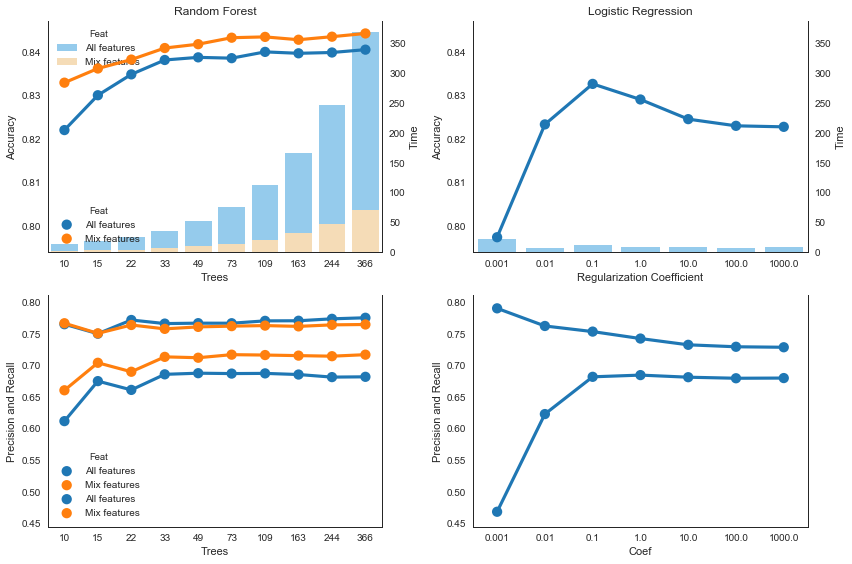

In [1627]:
sns.set_style('white', {'axes.linewidth':1})

# Plot results
fig = plt.figure(figsize=(12,8))

ax1, ax3 = fig.add_subplot(221), fig.add_subplot(222)
ax2, ax4 = ax1.twinx(), ax3.twinx()
ax1.get_shared_y_axes().join(ax1, ax3)
ax2.get_shared_y_axes().join(ax2, ax4)

sns.pointplot(x='Trees', y='Accy', hue='Feat', data=tree_results, ax=ax1)
sns.barplot(x='Trees', y='Time', hue='Feat', data=tree_results, palette=pltte[2:], ax=ax2,
           dodge=False)
ax1.set_title('Random Forest')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Trees')


sns.pointplot(x='Coef', y='Accy', data=coef_results, ax=ax3)
sns.barplot(x='Coef', y='Time', data=coef_results, color='lightskyblue', ax=ax4)
ax4.yaxis.tick_right()
ax3.set_title('Logistic Regression')
ax3.set_xlabel('Regularization Coefficient')
ax3.set_ylabel('Accuracy')

ax1.set_zorder(10), ax3.set_zorder(10)
ax1.patch.set_visible(False), ax3.patch.set_visible(False)

ax5 = fig.add_subplot(223)
ax6 = fig.add_subplot(224)
ax6.get_shared_y_axes().join(ax6, ax5)
sns.pointplot(x='Trees', y='Prec', hue='Feat', data=tree_results, ax=ax5)
sns.pointplot(x='Trees', y='Rec', hue='Feat', data=tree_results, ax=ax5)
sns.pointplot(x='Coef', y='Prec', data=coef_results, ax=ax6)
sns.pointplot(x='Coef', y='Rec', data=coef_results, ax=ax6)
ax5.set_ylabel('Precision and Recall')
ax6.set_ylabel('Precision and Recall')

plt.tight_layout()
sns.despine(right=False, left=False)
plt.show()

* __Random Forest__: As the number of trees grow so does the accuracy and run time (notice that we’re exponentially increasing the trees). By only including _Type_ and _Method_ as categorical variables, our algorithm runs much faster while manages to increase accuracy. This happens by reducing number of false negatives, which increases recall. However, as mentioned before, we’re more concerned about precision, and our results here doesn’t improve with more trees.

* __Logistic Regression__: The algorithm best performance clearly occurs with a 0.1 coefficient.

## Optimize Parameters for precision - Random Search
At this point we’re going to focus only on Random Forest (ADD REASONS).

We’ve seen the effect that number of threes has on the results, but that is just one of the many parameters that we can adjust. However, trying all the possible combinations from assigning a list of values to each parameter can be very computationally intensive. To accelerate the process of hyper-tuning the parameters we’re going to run a random search of combinations and see if we find any patters that can helps us narrow the values that we finally want to test for each parameter. 

We’re going to see which values yield a higher precision, and which values increase recall,

In [599]:
random_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [10, 20, 40, 80, 120],
    'max_depth': [3, 5, 10, 15, 25, None],
    'class_weight' : [{0: 0.7, 1: 0.3}, {0: 0.5, 1: 0.5}, {0: 0.33, 1: 0.67}],
    'max_features': [3, 5, 10]
}

random_search = RandomizedSearchCV(rfc, random_grid, n_iter=100, cv=5, verbose=1,
                                   scoring=scoring, refit='f1', random_state=13, n_jobs = -1)

random_search.fit(X_train_mix, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.9min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'min_samples_split': [3, 5, 10], 'n_estimators': [10, 20, 40, 80, 120], 'max_depth': [3, 5, 10, 15, 25, None], 'class_weight': [{0: 0.7, 1: 0.3}, {0: 0.5, 1: 0.5}, {0: 0.33, 1: 0.67}], 'max_features': [3, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=13, refit='f1',
          return_train_score='warn',
          scoring={'Accuracy': 'accuracy', 'Precision': 'precision', 'Recall': 'recall', 'f1': 'f1'},
          verbose=

In [621]:
rand_results = pd.DataFrame(random_search.cv_results_)
rand_test = rand_results[[col for col in rand_results if col.startswith('mean_test')]]
rand_test.columns = rand_test.columns.map(lambda x: x.split('_')[-1])
random_summary = pd.concat(objs=[rand_results.params, rand_test], axis=1)

In [1475]:
print('Top 5 Precision')
random_summary.sort_values(by='Precision', ascending=False).head()

Top 5 Precision


,params,Accuracy,Precision,Recall,f1
20,"{'n_estimators': 120, 'min_samples_split': 3, 'max_features': 3, 'max_depth': 3, 'class_weight': {0: 0.7, 1: 0.3}}",0.722271,0.953095,0.105764,0.190189
44,"{'n_estimators': 20, 'min_samples_split': 3, 'max_features': 3, 'max_depth': 5, 'class_weight': {0: 0.7, 1: 0.3}}",0.770438,0.913333,0.284400,0.432017
67,"{'n_estimators': 80, 'min_samples_split': 10, 'max_features': 3, 'max_depth': 5, 'class_weight': {0: 0.7, 1: 0.3}}",0.772302,0.912746,0.290282,0.440248
88,"{'n_estimators': 80, 'min_samples_split': 3, 'max_features': 5, 'max_depth': 3, 'class_weight': {0: 0.7, 1: 0.3}}",0.765780,0.904531,0.270220,0.415584
17,"{'n_estimators': 20, 'min_samples_split': 5, 'max_features': 5, 'max_depth': 3, 'class_weight': {0: 0.7, 1: 0.3}}",0.772022,0.901193,0.293905,0.443067


In [1476]:
print('Top 5 Recall')
random_summary.sort_values(by='Recall', ascending=False).head()

Top 5 Recall


,params,Accuracy,Precision,Recall,f1
75,"{'n_estimators': 20, 'min_samples_split': 10, 'max_features': 10, 'max_depth': 3, 'class_weight': {0: 0.33, 1: 0.67}}",0.804724,0.635099,0.864515,0.732219
91,"{'n_estimators': 40, 'min_samples_split': 3, 'max_features': 10, 'max_depth': 5, 'class_weight': {0: 0.33, 1: 0.67}}",0.818838,0.657560,0.862705,0.746250
6,"{'n_estimators': 40, 'min_samples_split': 5, 'max_features': 10, 'max_depth': 5, 'class_weight': {0: 0.33, 1: 0.67}}",0.818885,0.657618,0.862705,0.746295
60,"{'n_estimators': 20, 'min_samples_split': 10, 'max_features': 10, 'max_depth': 5, 'class_weight': {0: 0.33, 1: 0.67}}",0.817860,0.656175,0.862101,0.745120
35,"{'n_estimators': 80, 'min_samples_split': 5, 'max_features': 5, 'max_depth': 3, 'class_weight': {0: 0.33, 1: 0.67}}",0.811804,0.646947,0.860140,0.738408


Some patterns are summarized in the table below:

|Parameter    |High Precision        |High Recall             |
|-------------|:--------------------:|:----------------------:|
|Samples Split|Tends to be lower     |Tends to be higher      |
|Samples Split|Not clear             |Not Clear               |
|Max Features |3-5                   |10                      |
|Max Depth    |3                     |3-5                     |
|Class Weight |Train set distribution| opposite to train dist.|

The combinations with the highest precision have an extremely low recall and won’t work us. To see what parameters might work best for us we’re going to select only combinations with a precision and recall higher than 0.75 and 0.66 respectively, and sort the results by ‘f1’ score, which combines precision and recall.

In [1478]:
print('Top 10 f1 score with at least 0.75 precision and 0.65 recall')
random_summary[(random_summary.Precision > 0.75) & (random_summary.Recall > 0.65)
              ].sort_values(by='f1', ascending=False).head(10)

Top 10 f1 score with at least 0.75 precision and 0.65 recall


,params,Accuracy,Precision,Recall,f1
5,"{'n_estimators': 120, 'min_samples_split': 5, 'max_features': 10, 'max_depth': 15, 'class_weight': {0: 0.5, 1: 0.5}}",0.847487,0.761818,0.736573,0.748864
21,"{'n_estimators': 80, 'min_samples_split': 5, 'max_features': 3, 'max_depth': 15, 'class_weight': {0: 0.5, 1: 0.5}}",0.848651,0.769046,0.728727,0.748286
83,"{'n_estimators': 120, 'min_samples_split': 3, 'max_features': 5, 'max_depth': 10, 'class_weight': {0: 0.5, 1: 0.5}}",0.846089,0.757810,0.737630,0.747412
81,"{'n_estimators': 40, 'min_samples_split': 5, 'max_features': 10, 'max_depth': 10, 'class_weight': {0: 0.5, 1: 0.5}}",0.845577,0.755702,0.739289,0.747229
37,"{'n_estimators': 120, 'min_samples_split': 5, 'max_features': 5, 'max_depth': 10, 'class_weight': {0: 0.5, 1: 0.5}}",0.845624,0.756175,0.738685,0.747144
10,"{'n_estimators': 80, 'min_samples_split': 10, 'max_features': 5, 'max_depth': 15, 'class_weight': {0: 0.5, 1: 0.5}}",0.846835,0.762548,0.732046,0.746899
28,"{'n_estimators': 20, 'min_samples_split': 3, 'max_features': 10, 'max_depth': 10, 'class_weight': {0: 0.5, 1: 0.5}}",0.843993,0.753899,0.735216,0.744168
99,"{'n_estimators': 40, 'min_samples_split': 10, 'max_features': 5, 'max_depth': None, 'class_weight': {0: 0.5, 1: 0.5}}",0.846369,0.766263,0.723145,0.743995
63,"{'n_estimators': 120, 'min_samples_split': 5, 'max_features': 5, 'max_depth': None, 'class_weight': {0: 0.5, 1: 0.5}}",0.846322,0.766859,0.721938,0.743644
49,"{'n_estimators': 20, 'min_samples_split': 3, 'max_features': 5, 'max_depth': 15, 'class_weight': {0: 0.5, 1: 0.5}}",0.844925,0.759905,0.728123,0.743554


Under this criteria, precision and recall move around 0.76 and 0.73 respectively. We’re being able to get almost the same precision as before but increasing significantly the recall. This will increase the name positives (false and true) identified, and give as more margin to adjust the decision threshold and increase the precision (by lowering the recall again).

## Optimize Parameters for precision - Grid Search
We’re now going to reduce our parameter grid to those values that have best worked to our interest. This time we’ll run all possible combinations and see what the best grid is. The process is very similar to what we just did.

In [645]:
param_grid = {
    'min_samples_split': [3, 5], 
    'n_estimators' : [20, 40, 80, 120],
    'max_depth': [10, 15, None],
    'class_weight' : [{0: 0.5, 1: 0.5}],
    'max_features': [5, 10]
}

grid_search = GridSearchCV(rfc, param_grid, scoring=scoring_2, refit='Precision', cv=5)

In [646]:
grid_search.fit(X_train_mix, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 20.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [3, 5], 'n_estimators': [20, 40, 80, 120], 'max_depth': [10, 15, None], 'class_weight': [{0: 0.5, 1: 0.5}], 'max_features': [5, 10]},
       pre_dispatch='2*n_jobs', refit='Precision',
       return_train_score='warn',
       scoring={'Accuracy': 'accuracy', 'Precision': 'precision', 'Recall': 'recall', 'f1': 'f1', 'tp': make_scorer(tp), 'fp': make_scorer(fp)},
       verbose=1)

In [649]:
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_test = grid_results[[col for col in grid_results if col.startswith('mean_test')][:4]]
grid_test.columns = grid_test.columns.map(lambda x: x.split('_')[-1])

for x in range(5):
    if x == 0:
        true_p = pd.Series(grid_results['split'+ str(x) + '_test_tp'])
        false_p = pd.Series(grid_results['split'+ str(x) + '_test_fp'])
        true_p = true_p.rename(false_p.name.split('_')[-1])
        false_p = false_p.rename(false_p.name.split('_')[-1])
    else:
        true_p += grid_results['split'+ str(x) + '_test_tp']
        false_p += grid_results['split'+ str(x) + '_test_fp']

grid_summary = pd.concat(objs=[grid_results['params'], grid_test, true_p, false_p], axis=1)

In [653]:
grid_summary[(grid_summary.Precision > 0.75) & (grid_summary.Recall > 0.65)
              ].sort_values(by='f1', ascending=False).head(10)

,params,Accuracy,Precision,Recall,f1,fp,fp
29,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 15, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 40}",0.848978,0.766518,0.735064,0.750324,4872.0,1486.0
19,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 15, 'max_features': 5, 'min_samples_split': 3, 'n_estimators': 120}",0.848232,0.763152,0.737478,0.749986,4888.0,1518.0
27,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 15, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 120}",0.847999,0.763559,0.735667,0.749265,4876.0,1511.0
31,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 15, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 120}",0.847487,0.761818,0.736573,0.748864,4882.0,1528.0
18,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 15, 'max_features': 5, 'min_samples_split': 3, 'n_estimators': 80}",0.847580,0.762316,0.735970,0.748800,4878.0,1522.0
22,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 15, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 80}",0.847720,0.764135,0.733404,0.748337,4861.0,1502.0
23,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 15, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 120}",0.847720,0.764145,0.733404,0.748328,4861.0,1502.0
1,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 10, 'max_features': 5, 'min_samples_split': 3, 'n_estimators': 40}",0.847021,0.761306,0.735366,0.747973,4874.0,1530.0
15,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 10, 'max_features': 10, 'min_samples_split': 5, 'n_estimators': 120}",0.845437,0.753604,0.742759,0.747892,4923.0,1613.0
11,"{'class_weight': {0: 0.5, 1: 0.5}, 'max_depth': 10, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 120}",0.845484,0.754019,0.742156,0.747812,4919.0,1608.0


We slightly improve results, but nothing too impressive from what we already got with our random search. However still a very good improvement to the initial model.

## Tune Decision Threshold

As we’ve seen we need to find a balance between utilizing our operational salesforce and increasing call-precision. With the current results we get a total of 6358 leads identified, 4872 are positive and 1486 are false, that gives a precision of 0.77 and recall of 0.74 (1755 false negatives that we miss).

Our capacity is 5070, still below the number of positives we get. To improve the results we can change the threshold of probability that defines a positive (0.5 probability by default). This will increase the number of false negatives, but positives will be more likely to be true. 

To optimize the threshold we need to look at how it interacts with precision and recall in our model. We’re going to plot a chat that shows the evolution of precision and recall along the decision threshold and how that translated in number of false and true positives.

Our optimal point in the threshold maximizes the precision while feeding enough leads to the call-center to work full capacity.


In [671]:
rfc_best = ensemble.RandomForestClassifier(random_state=13, 
                                           class_weight ={0: 0.5, 1: 0.5},
                                           max_depth=15,
                                           max_features=10,
                                           min_samples_split=5,
                                           n_estimators=40)

scores_best = cross_validate(rfc_best, X_train_mix, y_train, cv=5, scoring=scoring_2)

In [683]:
print('           Run Time:', scores_best['fit_time'].sum() + scores_best['score_time'].sum())
print('Train Mean Accuracy:', scores_best['train_Accuracy'].mean())
print(' Test Mean Accuracy:', scores_best['test_Accuracy'].mean())
print('  2 Std. Deviations:', scores_best['test_Accuracy'].std()*2)
print('     Test Precision:', scores_best['test_Precision'].mean())
print('        Test Recall:', scores_best['test_Recall'].mean())
print('            Test f1:', scores_best['test_f1'].mean())
print('     True Positives:', scores_best['test_tp'].sum())
print('    False Positives:', scores_best['test_fp'].sum())

           Run Time: 11.90077018737793
Train Mean Accuracy: 0.9297991744893824
 Test Mean Accuracy: 0.8489774864629419
  2 Std. Deviations: 0.00385026715323383
     Test Precision: 0.7665176908666983
        Test Recall: 0.735065198212812
            Test f1: 0.7503240077586554
     True Positives: 4872
    False Positives: 1486


In [690]:
y_proba = cross_val_predict(rfc_best, X_train_mix, y_train, cv=5, method='predict_proba')[:, 1]

In [1501]:
prec, rec, thres = precision_recall_curve(y_train, y_proba)
print('len prec:', len(prec), 'len rec:',len(rec), 'len thres:',len(thres))
# get same lenght to all vars
prec = prec[:-1]
rec = rec[:-1] 

len prec: 17910 len rec: 17910 len thres: 17909


In [766]:
def adjusted_threshold(y_proba, thres):
    return [1 if y >= thres else 0 for y in y_proba]

In [1386]:
opt_thres = ''
t_results = []
for t in np.arange(0, 1, 0.01):
    y_pred_ = adjusted_threshold(y_proba, t)
    tp_ = tp(y_train, y_pred_)
    fp_ = fp(y_train, y_pred_)
    total_p = tp_ + fp_
    t_results.append([t, tp_, total_p,])
    if tp_ + fp_ < 5070 and not opt_thres:
        opt_thres = t - 0.01
        print('optimal threshold:', opt_thres)

t_results = pd.DataFrame(t_results,
                       columns=['Thres', 'TP', 'Total']
                      )

optimal threshold: 0.6


In [1497]:
len()

17909

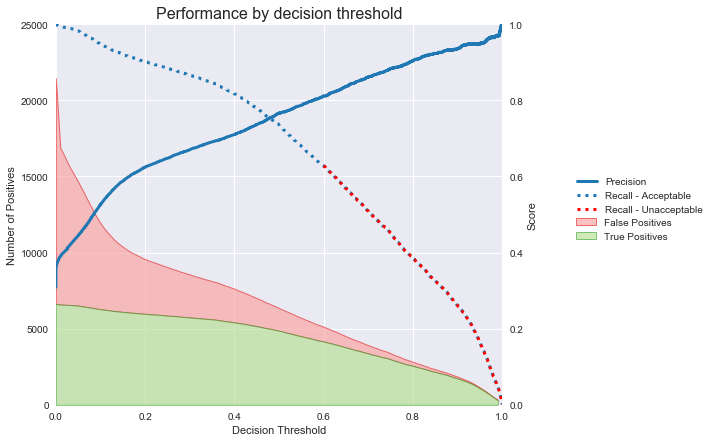

In [1525]:
plot_cs = sns.color_palette("Paired", 10)
above_t = len(thres[thres > 0.6])

fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)
ax1.fill_between(t_results.Thres, t_results.TP, t_results.Total, label='False Positives',
                 edgecolor=plot_cs[5], linewidth=1, facecolor=plot_cs[4], alpha=0.6)
ax1.fill_between(t_results.Thres, 0, t_results.TP, label='True Positives',
                 edgecolor=plot_cs[3], linewidth=1, facecolor=plot_cs[2], alpha=0.6)
ax1.set_ylabel('Number of Positives')
ax1.set_ylim(0, 25000)
ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax2.get_yticks())))
ax1.set_xlabel('Decision Threshold')

ax2 = ax1.twinx()
ax2.set_title('Performance by decision threshold', fontsize=16)
ax2.plot(thres, prec, color=plot_cs[1], label='Precision', linewidth=3)
ax2.plot(thres, rec, color=plot_cs[1], linewidth=3, linestyle=':',
         label='Recall - Acceptable')
ax2.plot(thres[-above_t:], rec[-above_t:], color='r', linewidth=3, linestyle=':',
        label='Recall - Unacceptable')
ax2.set_ylabel('Score')
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.grid(False)

ax1.legend(loc='center right', bbox_to_anchor=(1.4, 0.46))
ax2.legend(loc='center right', bbox_to_anchor=(1.47, 0.55))

plt.show()

0.6 is the highest we can go before having too many false negatives. Another issue that we have is that after a 0.5 threshold approximately, the recall starts declining much faster than the precision increases, so we're increasing faster the number of false negatives that we reduce false positives. To increase our precision 4 percentual points is going down about 10 points.

## Run final model on test data
Finally we’re going our model with the test data that we’ve saved and see if the results are consistent. We hold a 20% of our data, so we’re going to scale that to the train set size (80% of data) to facilitate comparing number of calls.

In [877]:
# impute test missing values with median
imp.fit(train_adjstd[numeric])
te_imputed = array_to_df(imp.transform(test_adjstd[numeric]), test_adjstd[numeric])
test_imputed = pd.concat(objs=[test_adjstd[categoric + ['>3 Rooms']], te_imputed], axis=1)

In [884]:
X_test = test_imputed[numeric + ['Type', 'Method']]
X_test_dum = pd.get_dummies(X_test)
y_test = test_imputed['>3 Rooms']

In [886]:
rfc_best.fit(X_train_mix, y_train)
rfc_best.predict(X_test_dum)

array([0, 1, 0, ..., 0, 1, 0])

In [900]:
rfc_best.score(X_test_dum, y_test)

0.8480118914901523

In [891]:
rfc_best.score(X_train_mix, y_train)

0.9254669958541016

In [908]:
y_test_proba = rfc_best.predict_proba(X_test_dum)[:, 1]
y_test_pred_adjstd = adjusted_threshold(y_test_proba, 0.6)
test_tn = tn(y_test, y_test_pred_adjstd)
test_fp = fp(y_test, y_test_pred_adjstd)
test_fn = fn(y_test, y_test_pred_adjstd)
test_tp = tp(y_test, y_test_pred_adjstd)


In [925]:
scaler = round(len(train)/len(test), 0)
test_tn_scaled = int(test_tn * scaler)
test_fp_scaled = int(test_fp * scaler)
test_fn_scaled = int(test_fn * scaler)
test_tp_scaled = int(test_tp * scaler)

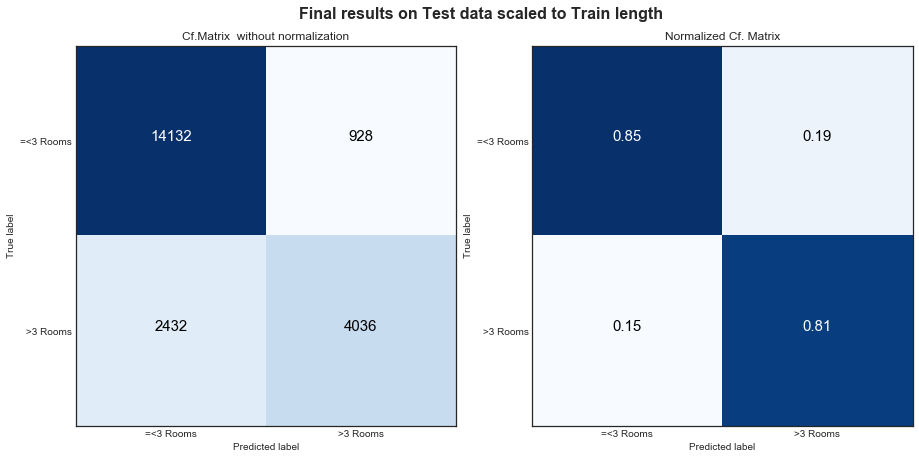

In [926]:
sns.set_style('white')
cnf_matrix = np.array([[test_tn_scaled, test_fp_scaled],[test_fn_scaled, test_tp_scaled]])
np.set_printoptions(precision=2)
class_names = ['=<3 Rooms', '>3 Rooms']

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
for ax in (ax1, ax2):
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=True if ax == ax2 else False,
                          title=('Normalized Cf. Matrix' if ax == ax2 else 
                                 'Cf.Matrix  without normalization')
                         )
plt.suptitle('Final results on Test data scaled to Train length', y=0.9, fontsize=16, fontweight='bold')
plt.show()